# Import necessary libraries

In [1]:
pip install numpy pandas scikit-learn matplotlib seaborn statsmodels xgboost catboost scikeras skl2onnx onnx onnxruntime tf2onnx


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from sklearn.utils import class_weight
from scikeras.wrappers import KerasClassifier
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import tf2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, StringTensorType, Int64TensorType
import warnings
warnings.filterwarnings('ignore')

# Load and Scale Data

In [3]:
df = pd.read_csv("heart_2022_with_nans.csv")
print(df.shape)

(445132, 40)


In [4]:
nan_counts = df.isna().sum().sort_values(ascending=False)
print(nan_counts)

TetanusLast10Tdap            82516
PneumoVaxEver                77040
HIVTesting                   66127
ChestScan                    56046
CovidPos                     50764
HighRiskLastYear             50623
BMI                          48806
FluVaxLast12                 47121
AlcoholDrinkers              46574
WeightInKilograms            42078
ECigaretteUsage              35660
SmokerStatus                 35462
HeightInMeters               28652
DifficultyErrands            25656
DifficultyConcentrating      24240
DifficultyWalking            24012
DifficultyDressingBathing    23915
BlindOrVisionDifficulty      21564
DeafOrHardOfHearing          20647
RaceEthnicityCategory        14057
RemovedTeeth                 11360
PhysicalHealthDays           10927
AgeCategory                   9079
MentalHealthDays              9067
LastCheckupTime               8308
SleepHours                    5453
HadAngina                     4405
HadSkinCancer                 3143
HadHeartAttack      

In [5]:
nan_percent = (df.isna().mean() * 100).sort_values(ascending=False)
print(nan_percent[nan_percent > 0])

TetanusLast10Tdap            18.537423
PneumoVaxEver                17.307226
HIVTesting                   14.855593
ChestScan                    12.590872
CovidPos                     11.404258
HighRiskLastYear             11.372582
BMI                          10.964388
FluVaxLast12                 10.585849
AlcoholDrinkers              10.462964
WeightInKilograms             9.452926
ECigaretteUsage               8.011107
SmokerStatus                  7.966626
HeightInMeters                6.436742
DifficultyErrands             5.763684
DifficultyConcentrating       5.445576
DifficultyWalking             5.394355
DifficultyDressingBathing     5.372564
BlindOrVisionDifficulty       4.844406
DeafOrHardOfHearing           4.638399
RaceEthnicityCategory         3.157940
RemovedTeeth                  2.552052
PhysicalHealthDays            2.454777
AgeCategory                   2.039620
MentalHealthDays              2.036924
LastCheckupTime               1.866413
SleepHours               

In [6]:
df_clean = df.dropna()

print(df_clean.shape)

(246022, 40)


In [7]:
df_clean_nan_counts = df_clean.isna().sum().sort_values(ascending=False)
print(df_clean_nan_counts)

State                        0
Sex                          0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
BMI                          0
AlcoholDrinkers              0
HIVTesting                   0
FluVaxLast12                 0
PneumoVaxEver                0
TetanusLast10Tdap            0
HighRiskLastYear             0
DifficultyConcentrating      0
BlindOrVisionDifficulty      0
DeafOrHardOfHearing          0
HadHeartAttack               0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadAngina                    0
HadDiabetes                  0
HadStrok

In [8]:
X = df_clean.drop('HadHeartAttack', axis=1)
y = df_clean['HadHeartAttack']

print(X.shape, y.shape)

(246022, 39) (246022,)


In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

target_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Target mapping:", target_mapping)

Target mapping: {'No': np.int64(0), 'Yes': np.int64(1)}


In [10]:
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

print("Numeric columns:", list(num_cols))
print("Size of numeric columns:", len(num_cols))
print("Categorical columns:", list(cat_cols))
print("Size of categorical columns:", len(cat_cols))

Numeric columns: ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']
Size of numeric columns: 6
Categorical columns: ['State', 'Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']
Size of categorical columns: 33


In [11]:
label_encoders = {}   # to store encoders per column
label_mappings = {}   # to store mappings per column

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

    # Save the encoder and mapping
    label_encoders[col] = le
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [12]:
for col, mapping in label_mappings.items():
    print(f"{col}:", mapping)

State: {'Alabama': np.int64(0), 'Alaska': np.int64(1), 'Arizona': np.int64(2), 'Arkansas': np.int64(3), 'California': np.int64(4), 'Colorado': np.int64(5), 'Connecticut': np.int64(6), 'Delaware': np.int64(7), 'District of Columbia': np.int64(8), 'Florida': np.int64(9), 'Georgia': np.int64(10), 'Guam': np.int64(11), 'Hawaii': np.int64(12), 'Idaho': np.int64(13), 'Illinois': np.int64(14), 'Indiana': np.int64(15), 'Iowa': np.int64(16), 'Kansas': np.int64(17), 'Kentucky': np.int64(18), 'Louisiana': np.int64(19), 'Maine': np.int64(20), 'Maryland': np.int64(21), 'Massachusetts': np.int64(22), 'Michigan': np.int64(23), 'Minnesota': np.int64(24), 'Mississippi': np.int64(25), 'Missouri': np.int64(26), 'Montana': np.int64(27), 'Nebraska': np.int64(28), 'Nevada': np.int64(29), 'New Hampshire': np.int64(30), 'New Jersey': np.int64(31), 'New Mexico': np.int64(32), 'New York': np.int64(33), 'North Carolina': np.int64(34), 'North Dakota': np.int64(35), 'Ohio': np.int64(36), 'Oklahoma': np.int64(37), 

In [13]:
print(X.shape, y_encoded.shape)

(246022, 39) (246022,)


In [14]:
X[num_cols].head()

PhysicalHealthDays  MentalHealthDays  SleepHours  HeightInMeters  \
342                 4.0               0.0         9.0            1.60   
343                 0.0               0.0         6.0            1.78   
345                 0.0               0.0         8.0            1.85   
346                 5.0               0.0         9.0            1.70   
347                 3.0              15.0         5.0            1.55   

     WeightInKilograms    BMI  
342              71.67  27.99  
343              95.25  30.13  
345             108.86  31.66  
346              90.72  31.32  
347              79.38  33.07

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X,        # features
    y_encoded,      # target
    test_size=0.2,  # 20% test data
    random_state=42, # ensures reproducibility
    stratify=y_encoded  # preserves target class distribution (useful for classification)
)

In [16]:
nan_counts_X_train = X_train.isna().sum().sort_values(ascending=False)
print(nan_counts_X_train)

State                        0
HeightInMeters               0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
WeightInKilograms            0
DifficultyConcentrating      0
BMI                          0
AlcoholDrinkers              0
HIVTesting                   0
FluVaxLast12                 0
PneumoVaxEver                0
TetanusLast10Tdap            0
HighRiskLastYear             0
DifficultyWalking            0
BlindOrVisionDifficulty      0
Sex                          0
HadAngina                    0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadStroke                    0
DeafOrHardOfHearing          0
HadAsthma                    0
HadSkinC

In [17]:
nan_counts_X_test = X_test.isna().sum().sort_values(ascending=False)
print(nan_counts_X_test)

State                        0
HeightInMeters               0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
WeightInKilograms            0
DifficultyConcentrating      0
BMI                          0
AlcoholDrinkers              0
HIVTesting                   0
FluVaxLast12                 0
PneumoVaxEver                0
TetanusLast10Tdap            0
HighRiskLastYear             0
DifficultyWalking            0
BlindOrVisionDifficulty      0
Sex                          0
HadAngina                    0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadStroke                    0
DeafOrHardOfHearing          0
HadAsthma                    0
HadSkinC

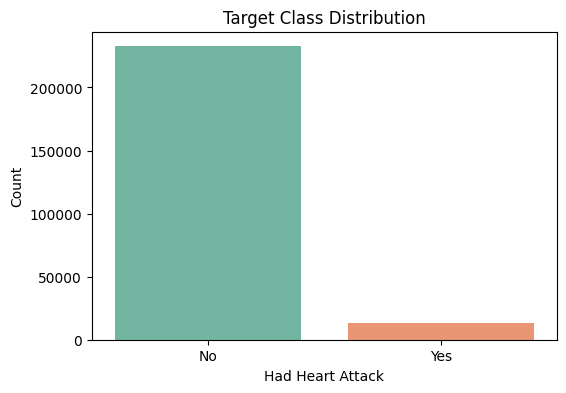

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(x='HadHeartAttack', data=df_clean, palette='Set2')
plt.title('Target Class Distribution')
plt.xlabel('Had Heart Attack')
plt.ylabel('Count')
plt.show()

In [19]:
df_corr = X_train.copy()
df_corr['HadHeartAttack'] = y_train
print(df_corr.shape)

(196817, 40)


In [20]:
df_corr.head()

State  Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
287809     36    1              1                 0.0               0.0   
306265     37    0              2                 0.0               0.0   
3666        0    1              2                10.0               5.0   
245526     31    1              2                 0.0               5.0   
28483       4    1              2                 5.0               0.0   

        LastCheckupTime  PhysicalActivities  SleepHours  RemovedTeeth  \
287809                3                   0         8.0             3   
306265                3                   0         6.0             1   
3666                  1                   1         6.0             0   
245526                3                   1         7.0             0   
28483                 3                   1         8.0             0   

        HadAngina  ...  WeightInKilograms    BMI  AlcoholDrinkers  HIVTesting  \
287809          1  ...              65.77  20.81                0           0   
306265          0  ...              63.50  21.93                0           0   
3666            0  ...              65.77  24.13                0           0   
245526          0  ...             104.33  36.02                1           0   
28483           1  ...              83.91  27.32                0           0   

        FluVaxLast12  PneumoVaxEver  TetanusLast10Tdap  HighRiskLastYear  \
287809             1              1                  0                 0   
306265             0              1                  1                 0   
3666               1              1                  1                 0   
245526             1              1                  1                 0   
28483              1              1                  2                 0   

        CovidPos  HadHeartAttack  
287809         0               0  
306265         0               0  
3666           2               1  
245526         0               0  
28483          2               1  

[5 rows x 40 columns]

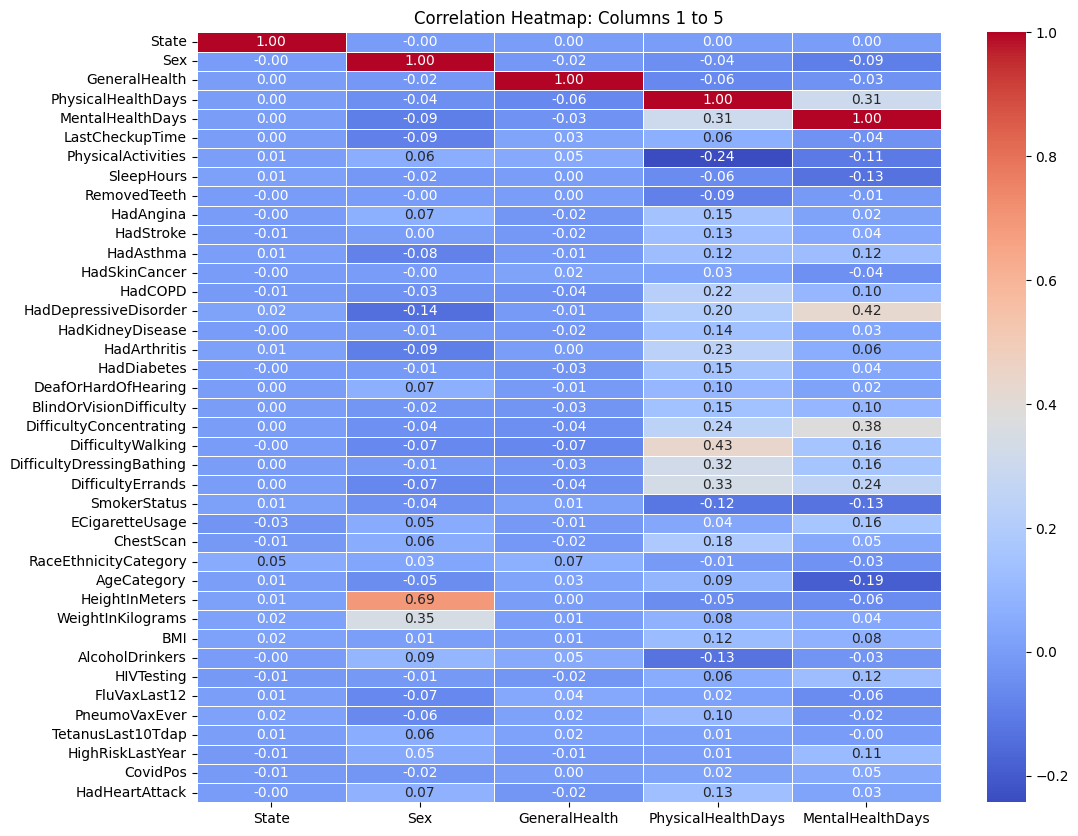

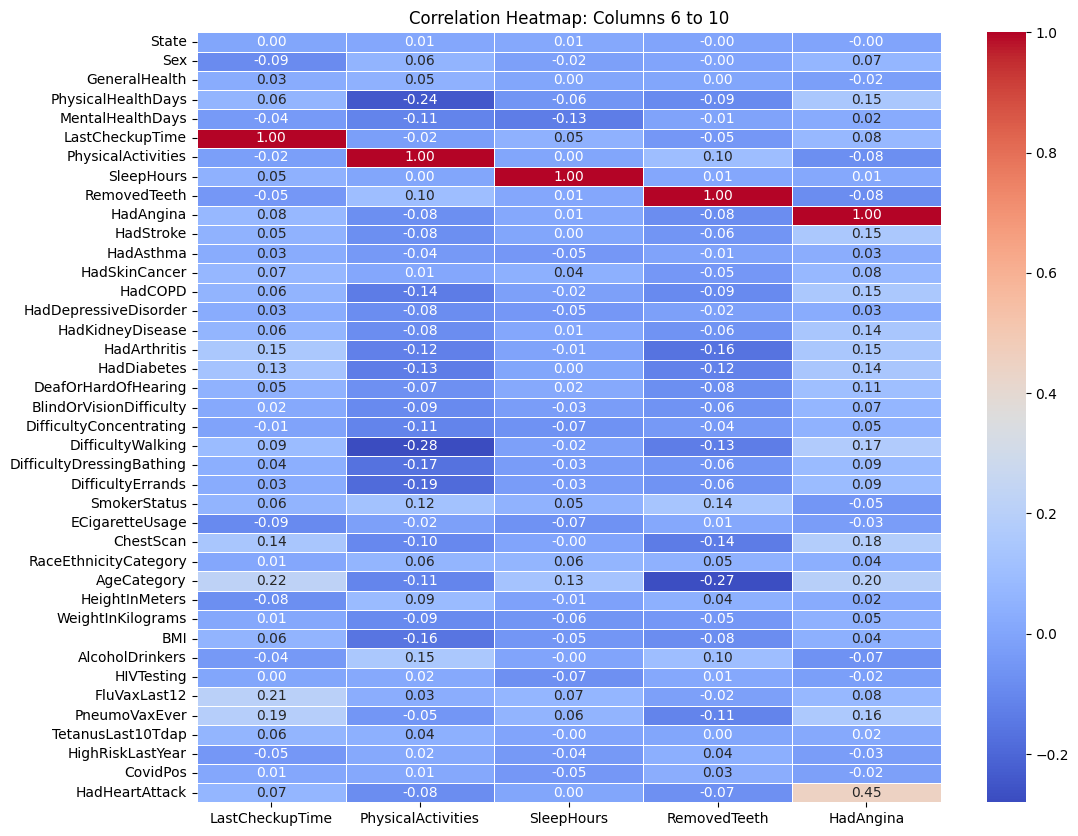

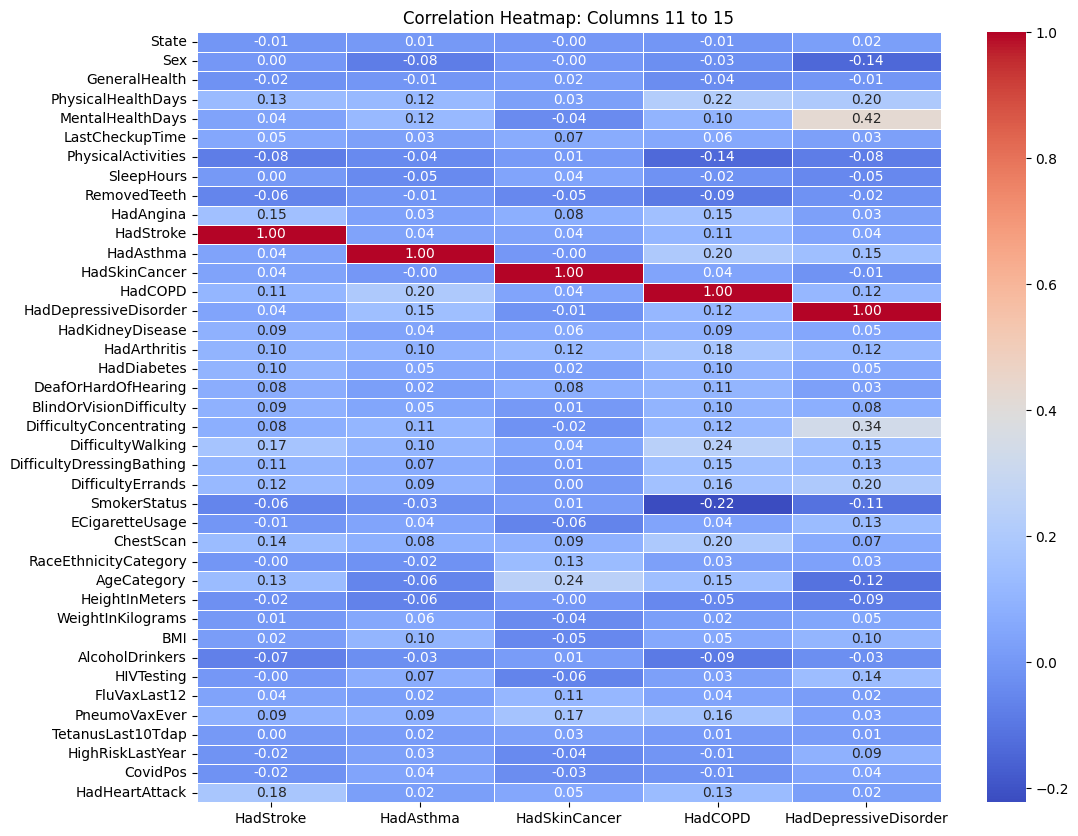

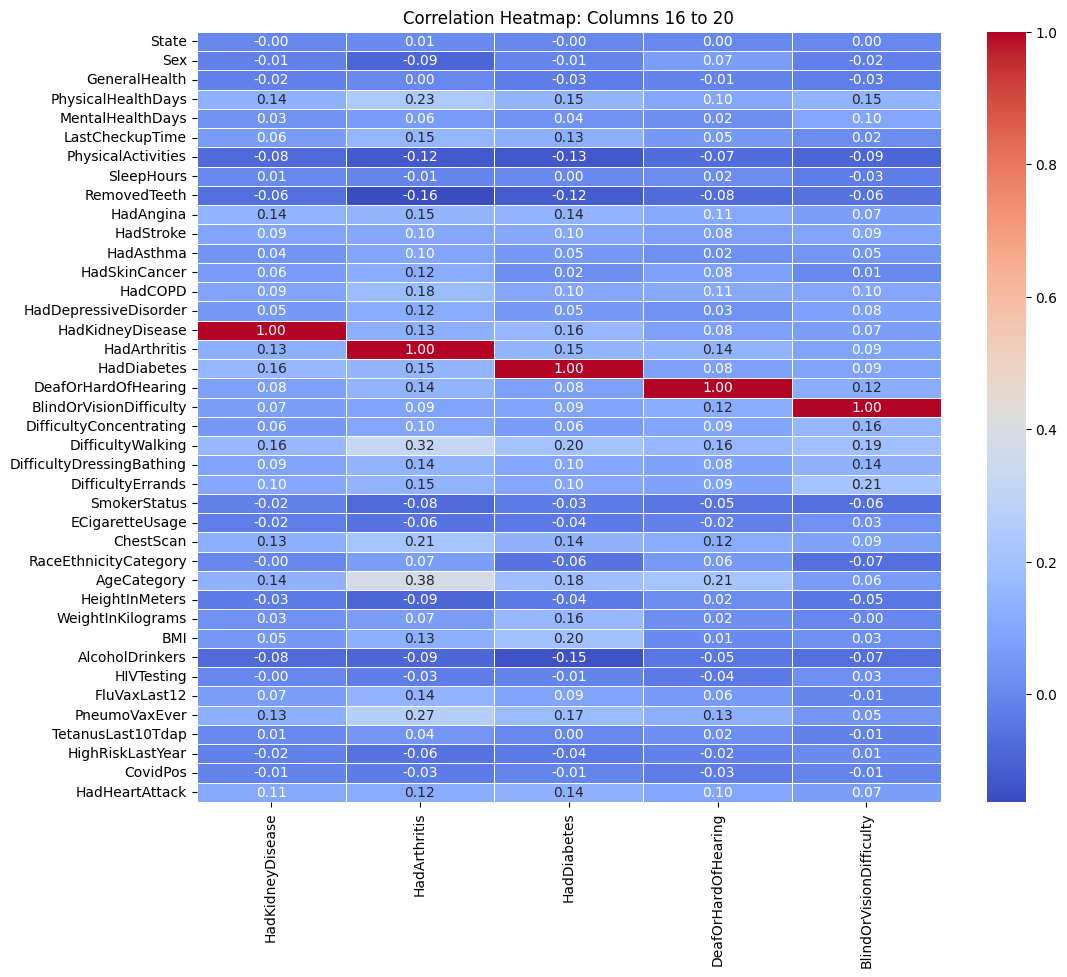

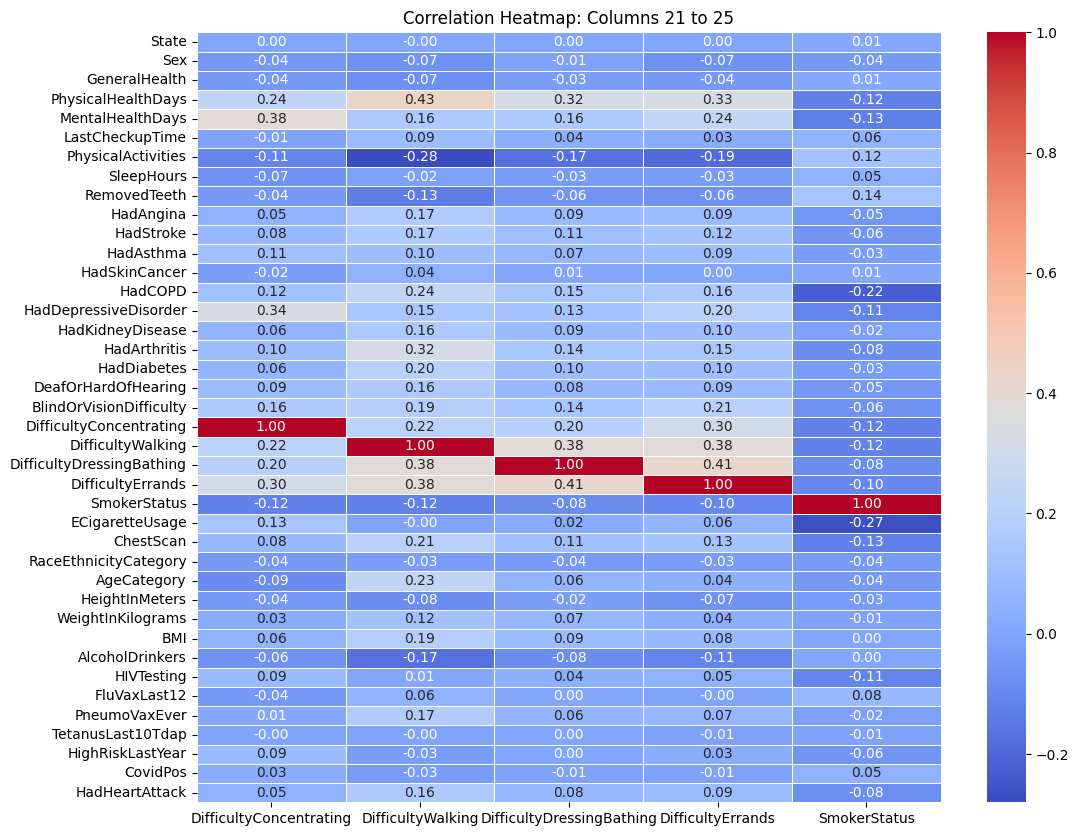

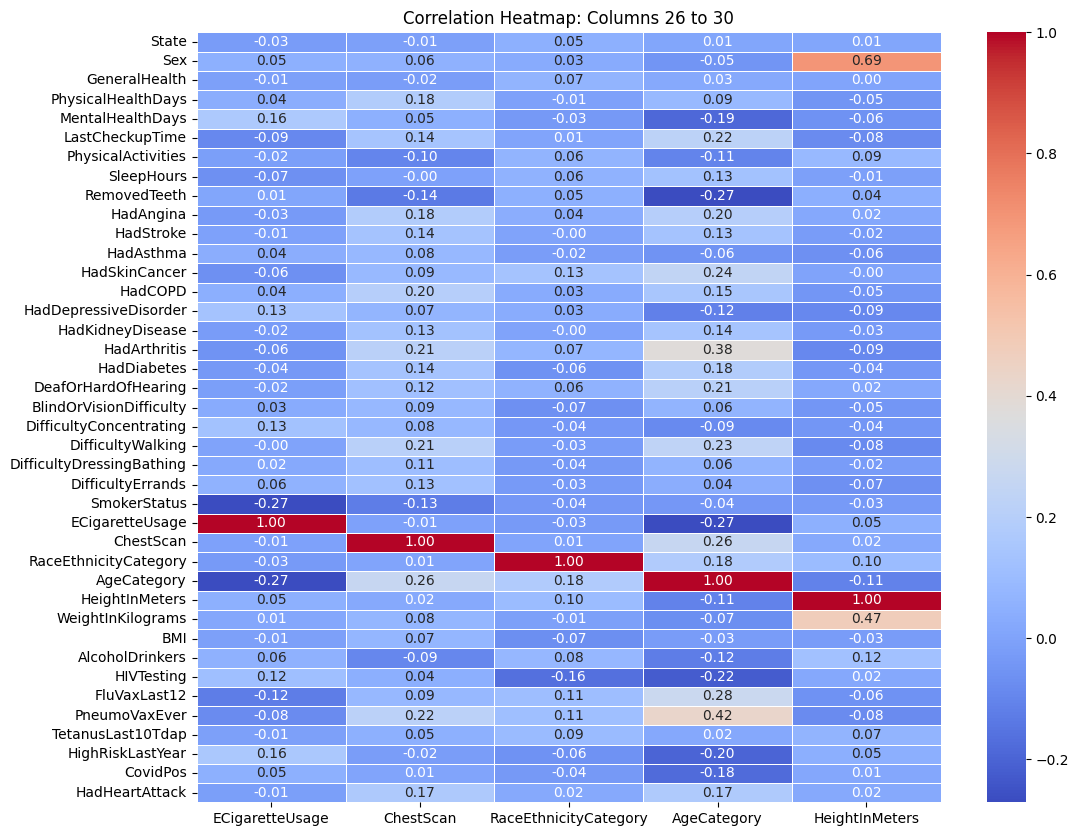

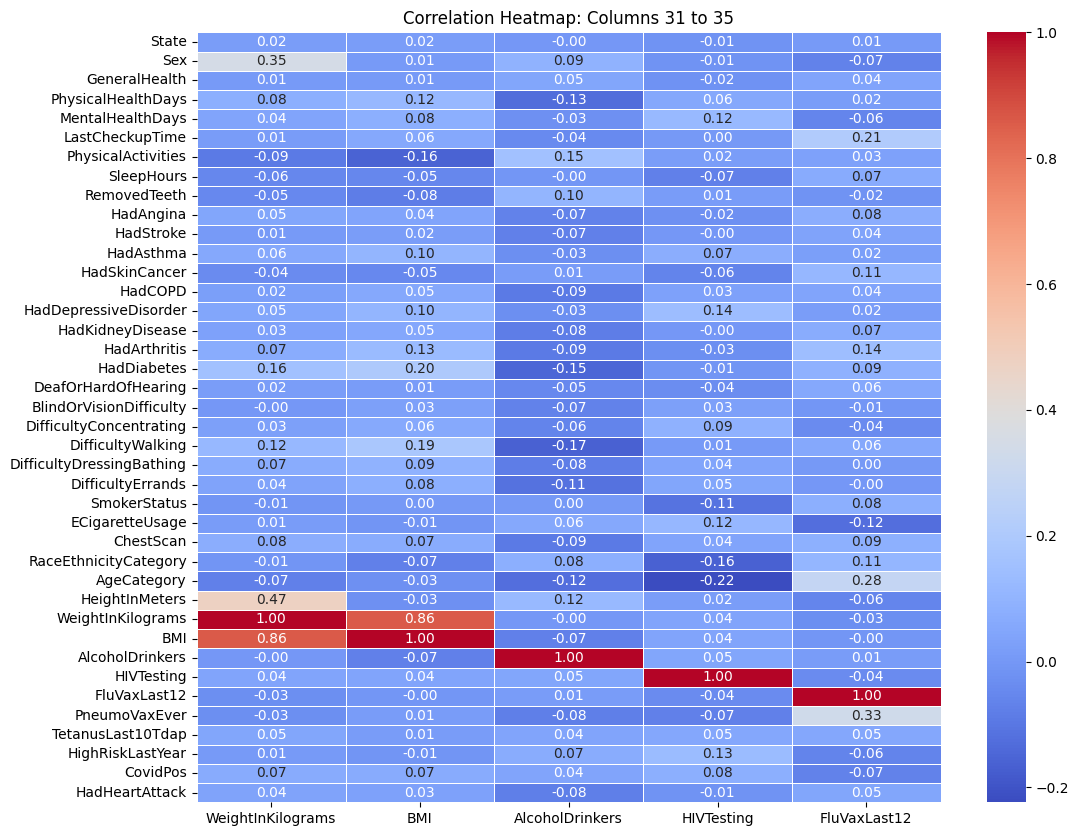

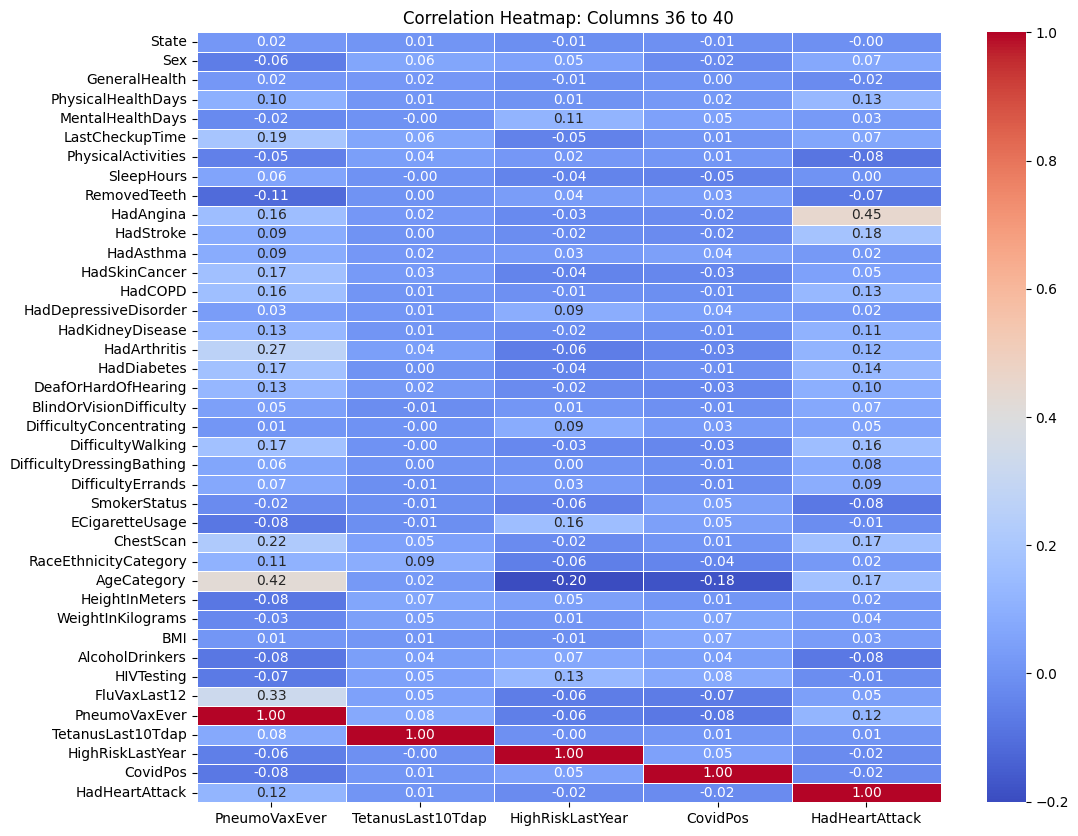

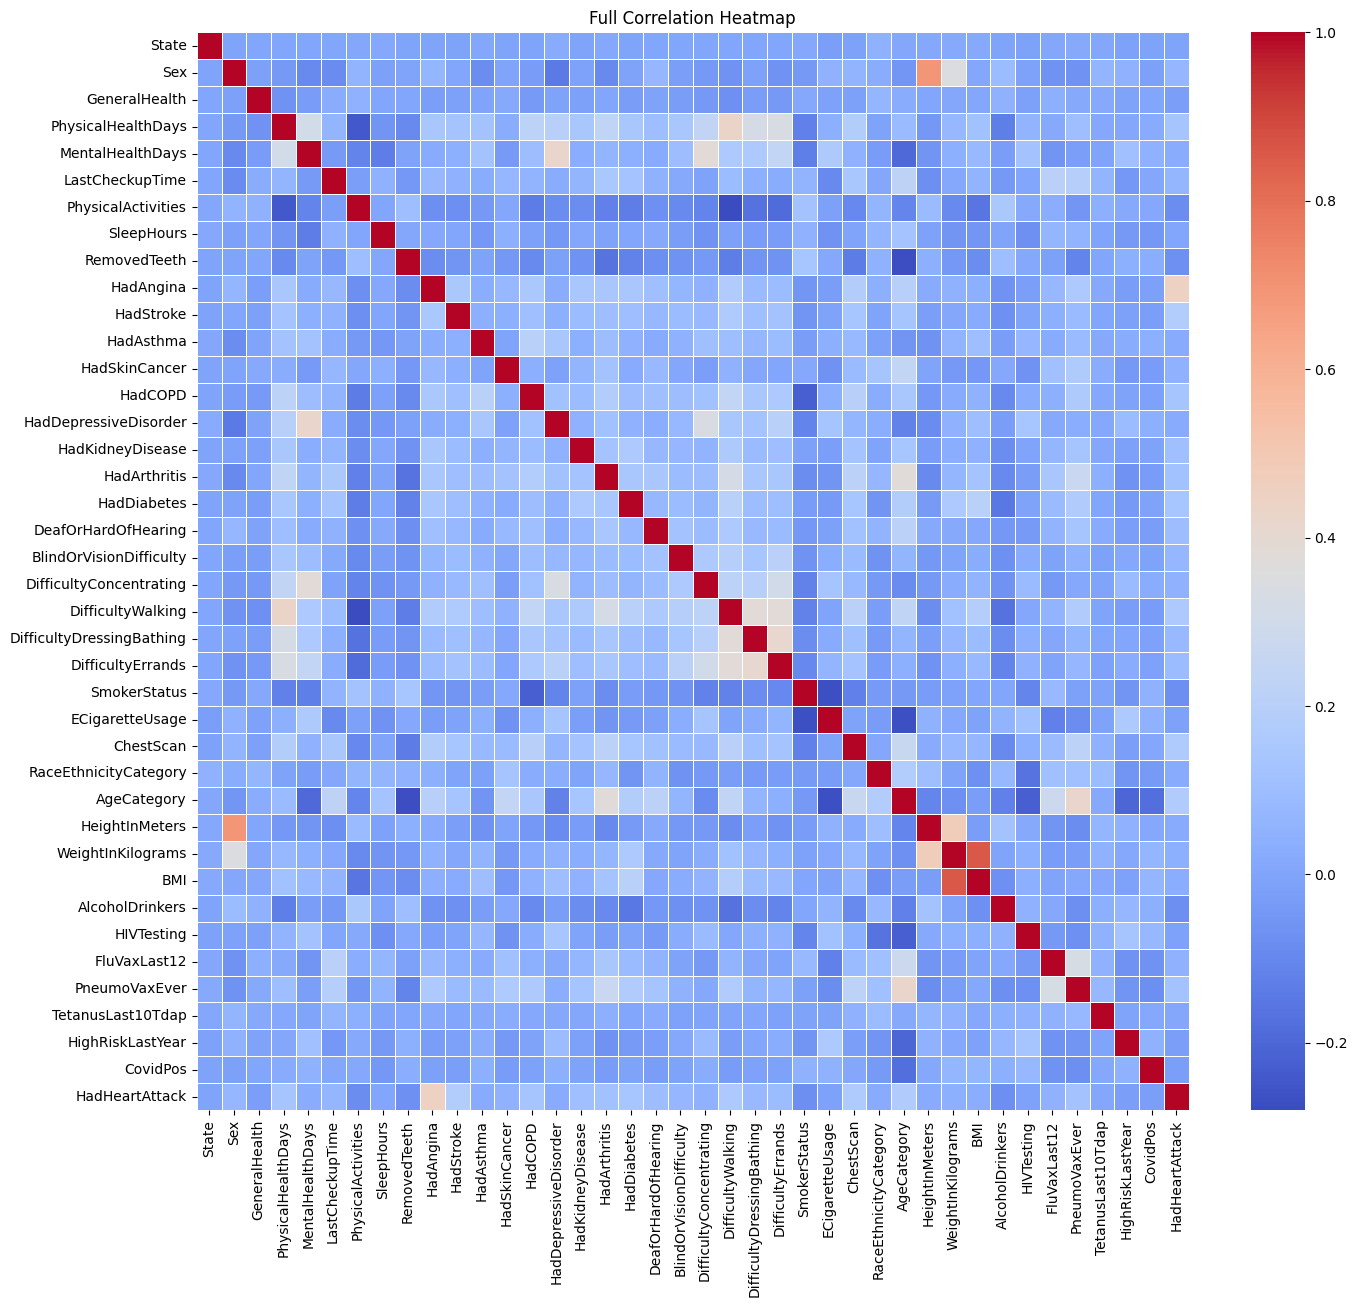

In [21]:
corr_matrix = df_corr.corr()
chunk_size = 5
features = corr_matrix.columns

for i in range(0, len(features), chunk_size):
    chunk_features = features[i:i+chunk_size]

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix.loc[:, chunk_features],  # all rows, chunk of columns
        annot=True,           # show values inside cells
        fmt=".2f",            # format to 2 decimal places
        cmap='coolwarm',
        linewidths=0.5
    )
    plt.title(f"Correlation Heatmap: Columns {i+1} to {i+len(chunk_features)}")
    plt.show()

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5
)
plt.title("Full Correlation Heatmap")
plt.show()

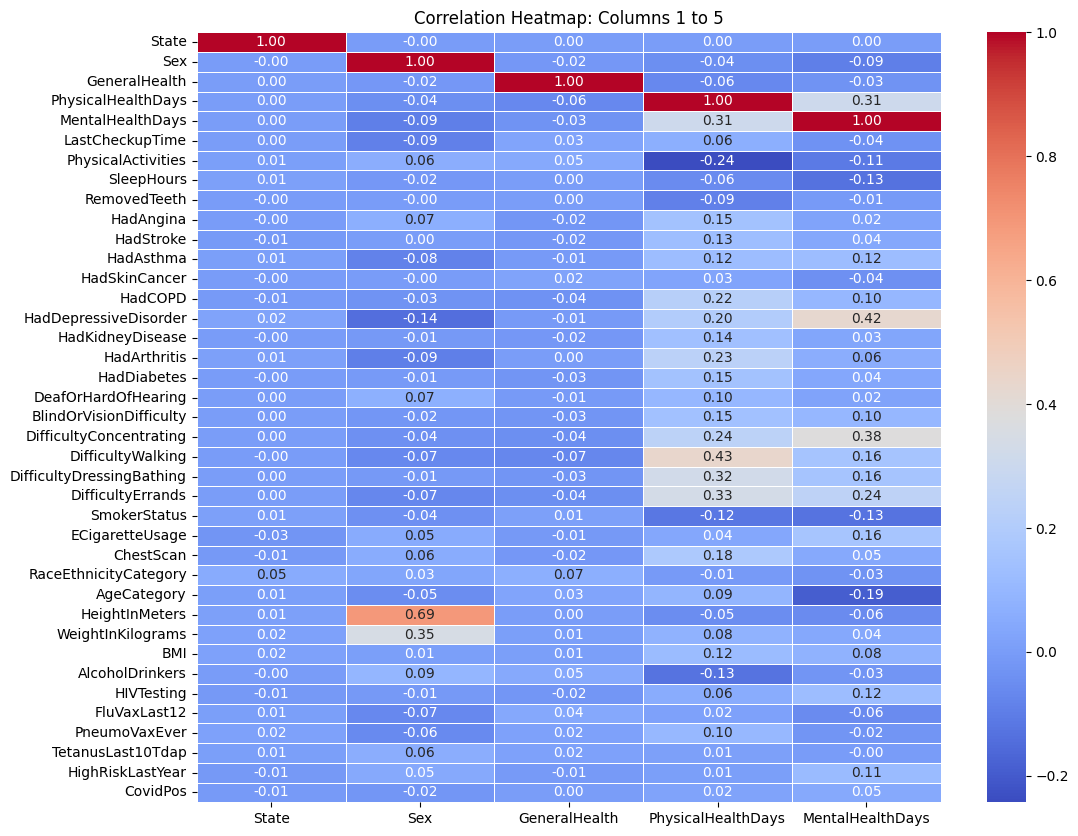

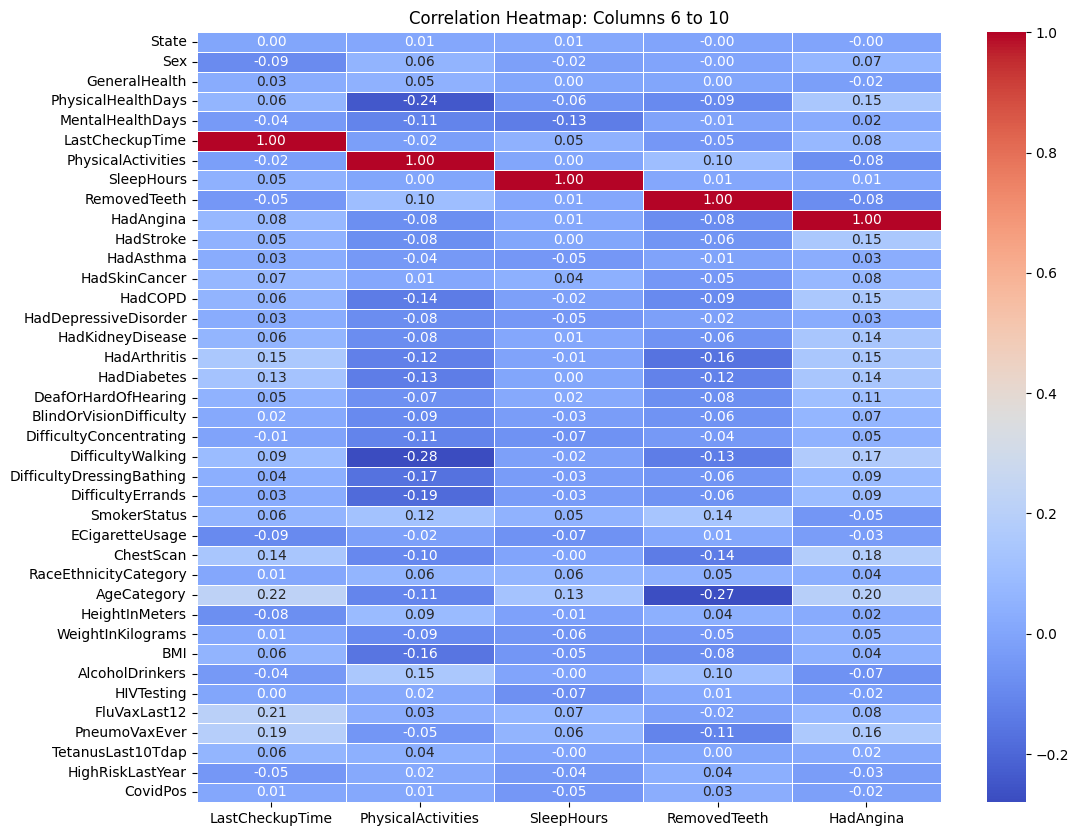

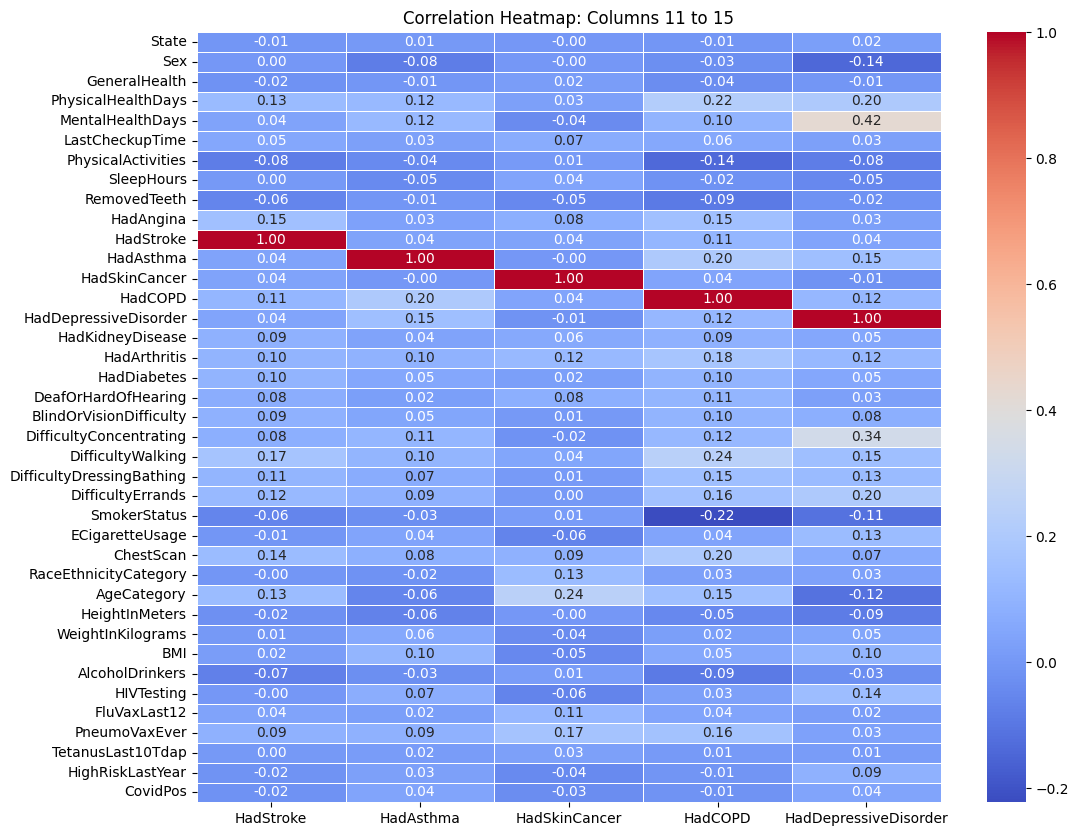

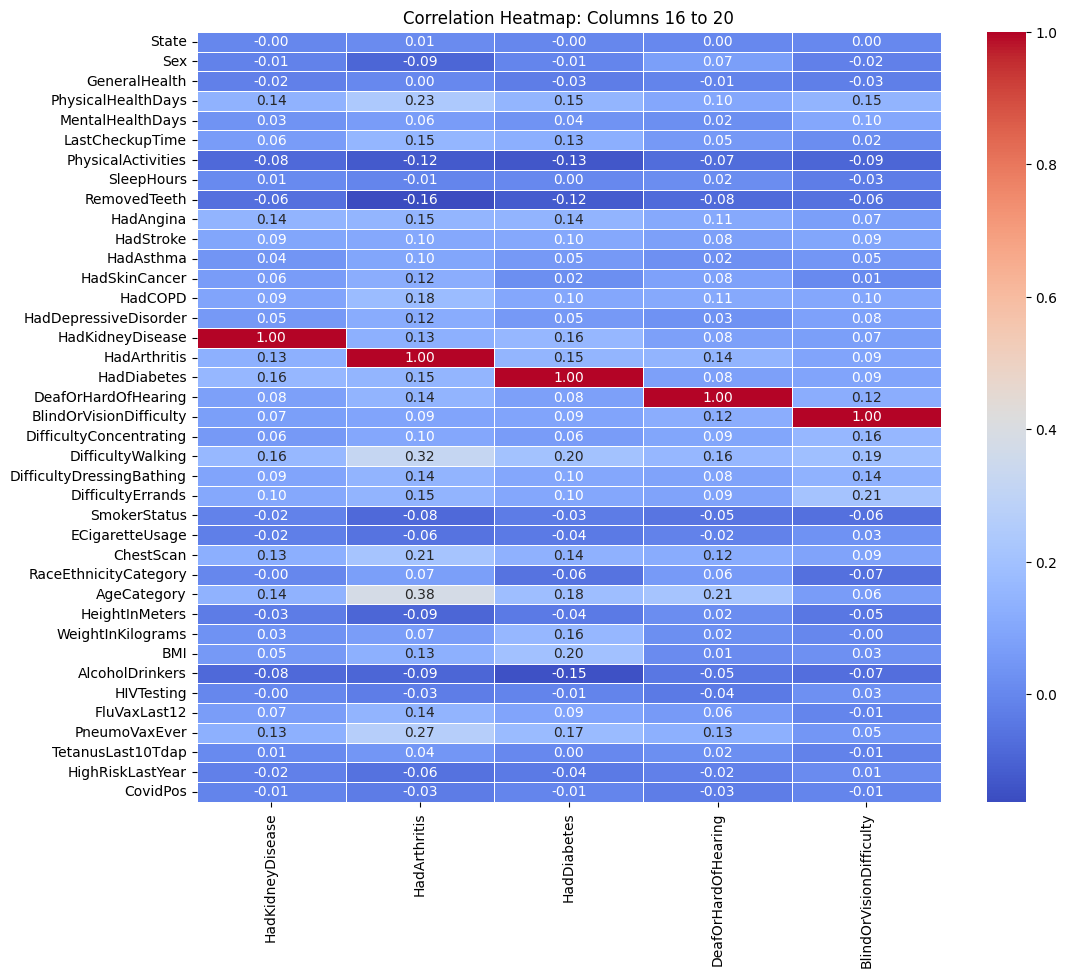

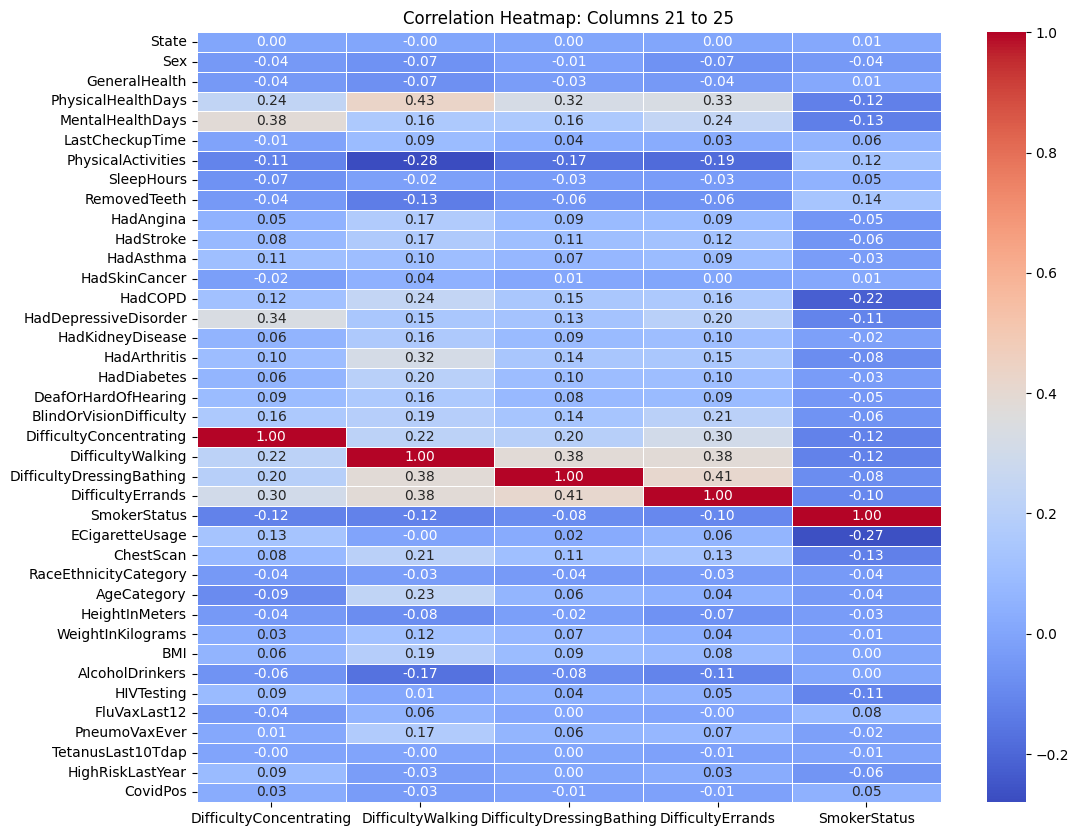

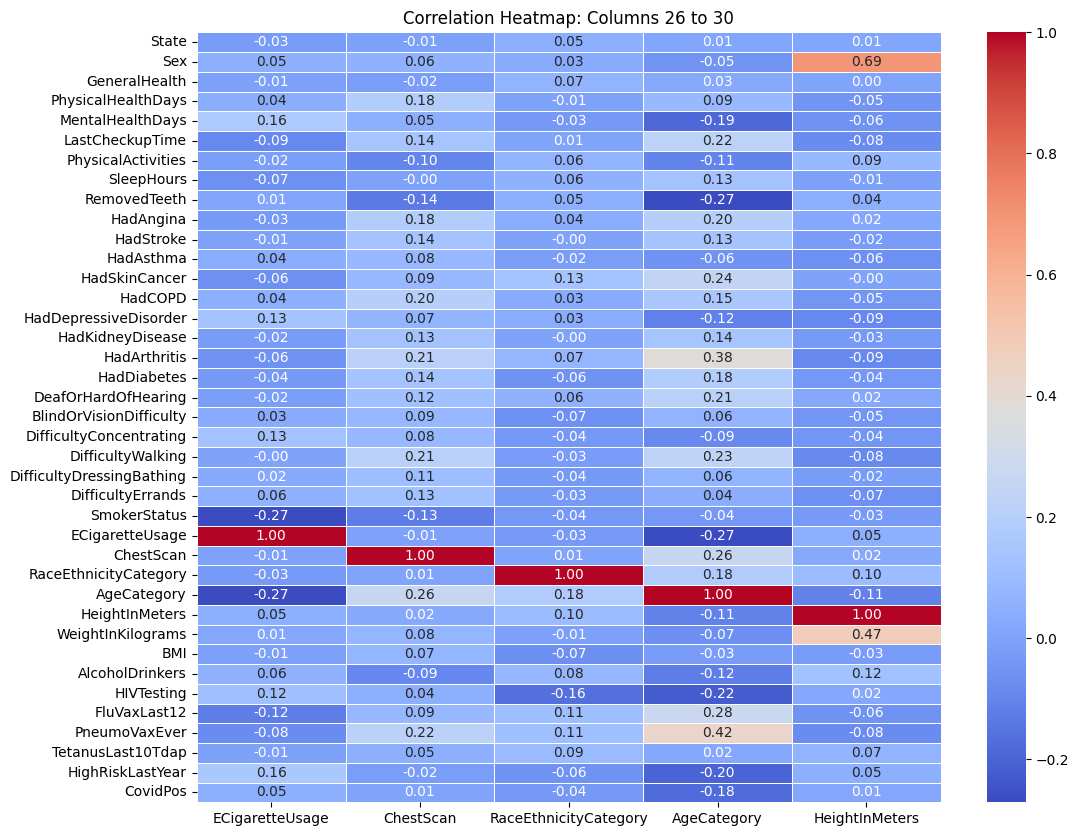

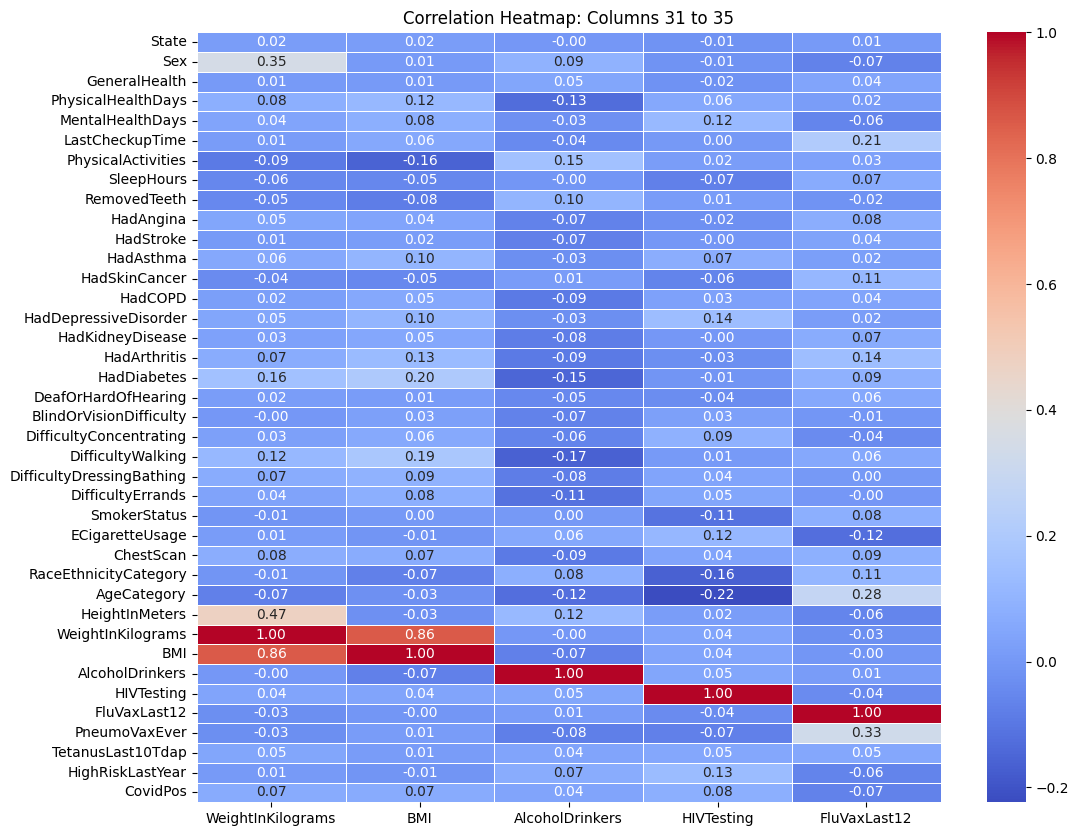

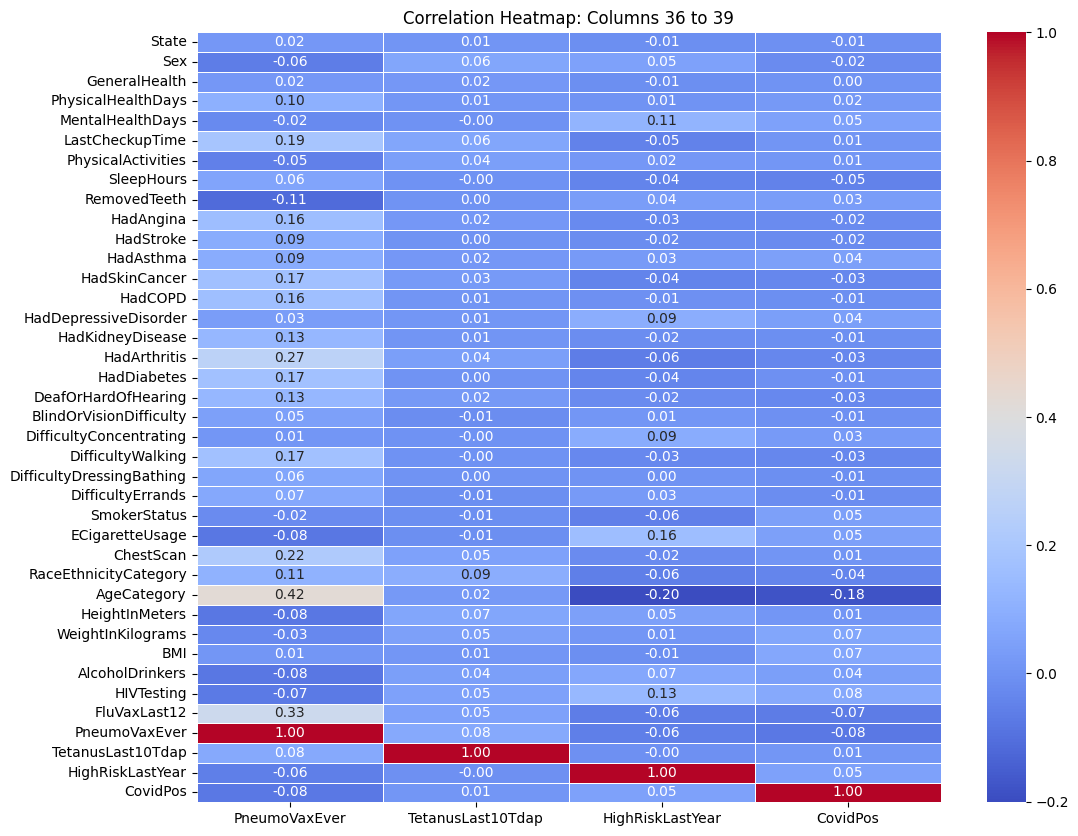

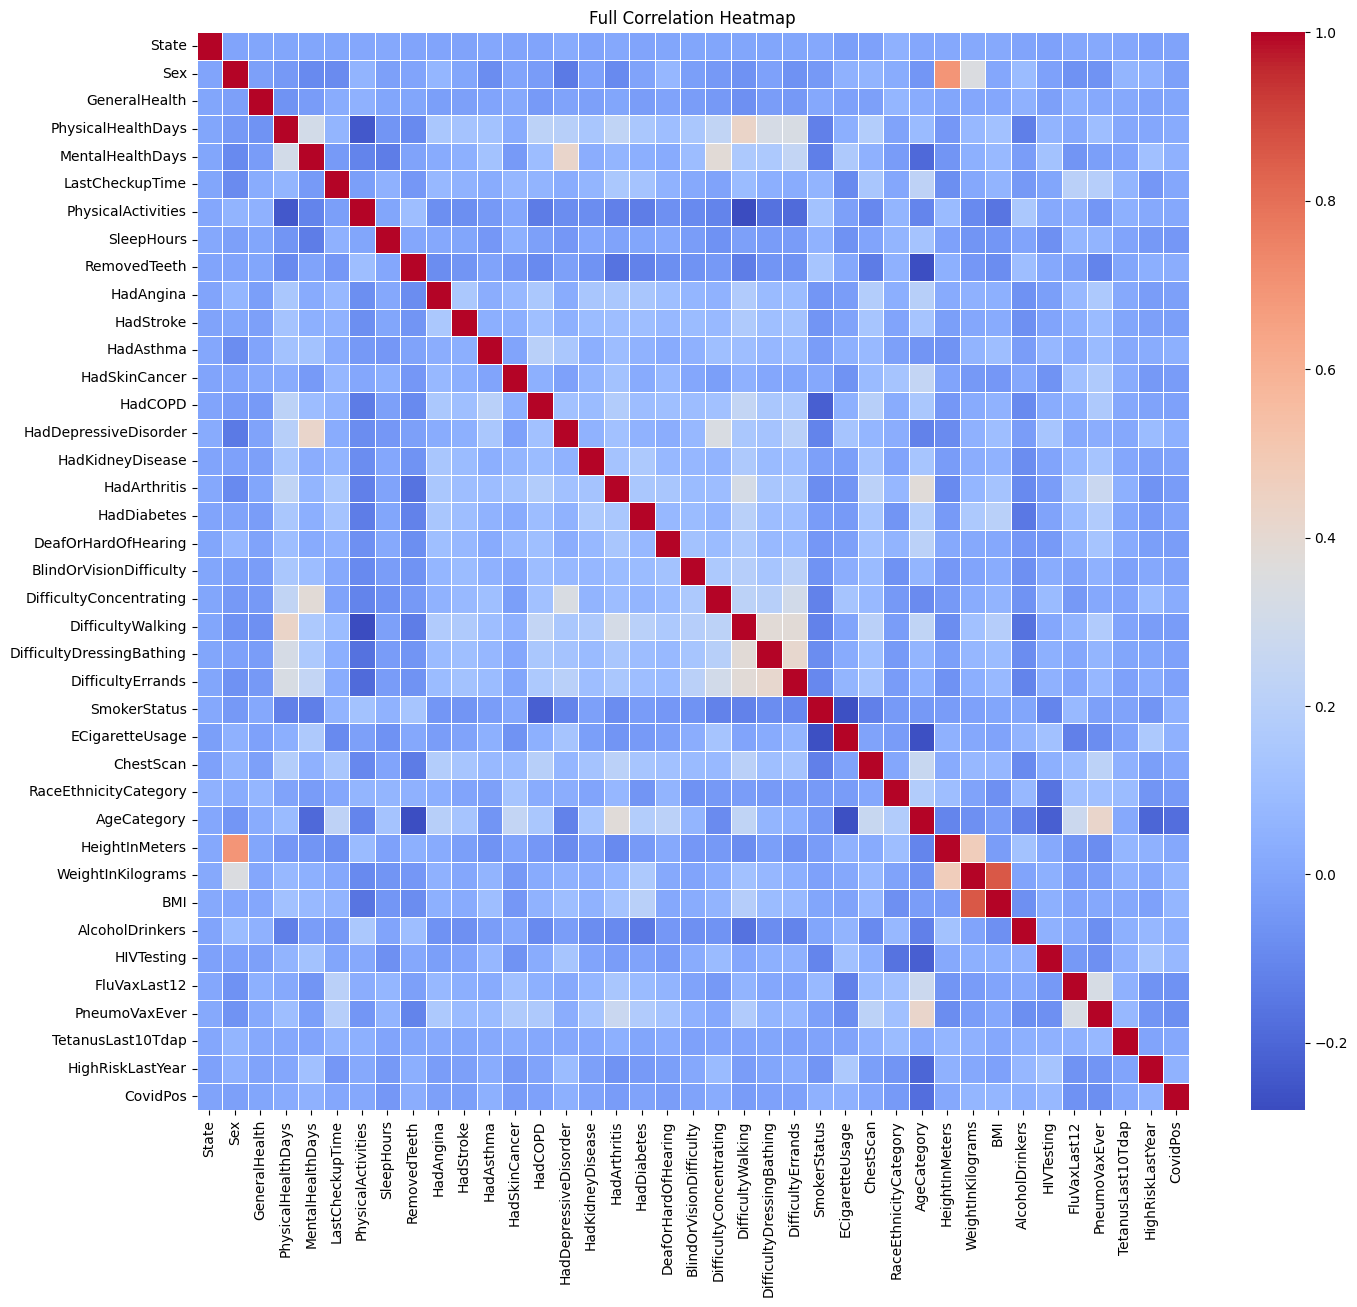

In [22]:
corr_matrix_multicollinearity = X_train.corr()
chunk_size = 5
features = corr_matrix_multicollinearity.columns

for i in range(0, len(features), chunk_size):
    chunk_features = features[i:i+chunk_size]

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix_multicollinearity.loc[:, chunk_features],  # all rows, chunk of columns
        annot=True,           # show values inside cells
        fmt=".2f",            # format to 2 decimal places
        cmap='coolwarm',
        linewidths=0.5
    )
    plt.title(f"Correlation Heatmap: Columns {i+1} to {i+len(chunk_features)}")
    plt.show()

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix_multicollinearity,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5
)
plt.title("Full Correlation Heatmap")
plt.show()

In [23]:
X_num = X_train[num_cols]
X_cat = X_train[cat_cols]
X_train_num = X_train[num_cols]
X_train_cat = X_train[cat_cols]

In [24]:
chi2_scores, p_values = chi2(X_cat, y_train)

chi2_df = pd.DataFrame({
    'Feature': cat_cols,
    'Chi2_Score': chi2_scores,
    'P_Value': p_values
})

chi2_df['P_Value'] = chi2_df['P_Value'].round(15)
chi2_df = chi2_df.sort_values(by='Chi2_Score', ascending=True).reset_index(drop=True)

print(chi2_df)

                      Feature    Chi2_Score       P_Value
0           TetanusLast10Tdap     13.942329  1.885053e-04
1                  HIVTesting     25.195892  5.179240e-07
2                       State     30.685590  3.034100e-08
3       RaceEthnicityCategory     53.919598  2.090000e-13
4             ECigaretteUsage     56.766021  4.900000e-14
5            HighRiskLastYear     81.179602  0.000000e+00
6               GeneralHealth     87.323102  0.000000e+00
7       HadDepressiveDisorder     90.896024  0.000000e+00
8                   HadAsthma     91.670023  0.000000e+00
9                    CovidPos    125.462375  0.000000e+00
10               FluVaxLast12    200.599789  0.000000e+00
11            LastCheckupTime    219.483373  0.000000e+00
12         PhysicalActivities    308.016511  0.000000e+00
13               SmokerStatus    417.665188  0.000000e+00
14              HadSkinCancer    450.241645  0.000000e+00
15    DifficultyConcentrating    496.678652  0.000000e+00
16            

In [25]:
f_scores, p_values = f_classif(X_num, y_train)

f_df = pd.DataFrame({
    'Feature': num_cols,
    'F_Score': f_scores,
    'P_Value': p_values
})

f_df['P_Value'] = f_df['P_Value'].round(15)

f_df = f_df.sort_values(by='F_Score', ascending=False).reset_index(drop=True)

# Display
print(f_df)

              Feature      F_Score   P_Value
0  PhysicalHealthDays  3526.447201  0.000000
1   WeightInKilograms   288.626715  0.000000
2                 BMI   176.670879  0.000000
3    MentalHealthDays   124.838566  0.000000
4      HeightInMeters   109.518433  0.000000
5          SleepHours     3.008540  0.082828


In [26]:
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=[col in cat_cols for col in X_train.columns])

mi_df = pd.DataFrame({'Feature': X_train.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)
print(mi_df)

                      Feature  MI Score
9                   HadAngina  0.047557
28                AgeCategory  0.017569
2               GeneralHealth  0.016382
26                  ChestScan  0.013962
7                  SleepHours  0.013468
8                RemovedTeeth  0.011935
21          DifficultyWalking  0.009756
10                  HadStroke  0.009287
17                HadDiabetes  0.008572
3          PhysicalHealthDays  0.007392
35              PneumoVaxEver  0.007101
16               HadArthritis  0.006399
13                    HadCOPD  0.006322
24               SmokerStatus  0.004471
15           HadKidneyDisease  0.004059
29             HeightInMeters  0.003999
18        DeafOrHardOfHearing  0.003651
6          PhysicalActivities  0.003143
23          DifficultyErrands  0.003116
30          WeightInKilograms  0.003056
5             LastCheckupTime  0.003038
32            AlcoholDrinkers  0.002851
1                         Sex  0.002770
22  DifficultyDressingBathing  0.002471


In [27]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]

print(vif_data)

              Feature        VIF
0  PhysicalHealthDays   1.382678
1    MentalHealthDays   1.420776
2          SleepHours  25.227743
3      HeightInMeters  48.168037
4   WeightInKilograms  77.095988
5                 BMI  72.874538


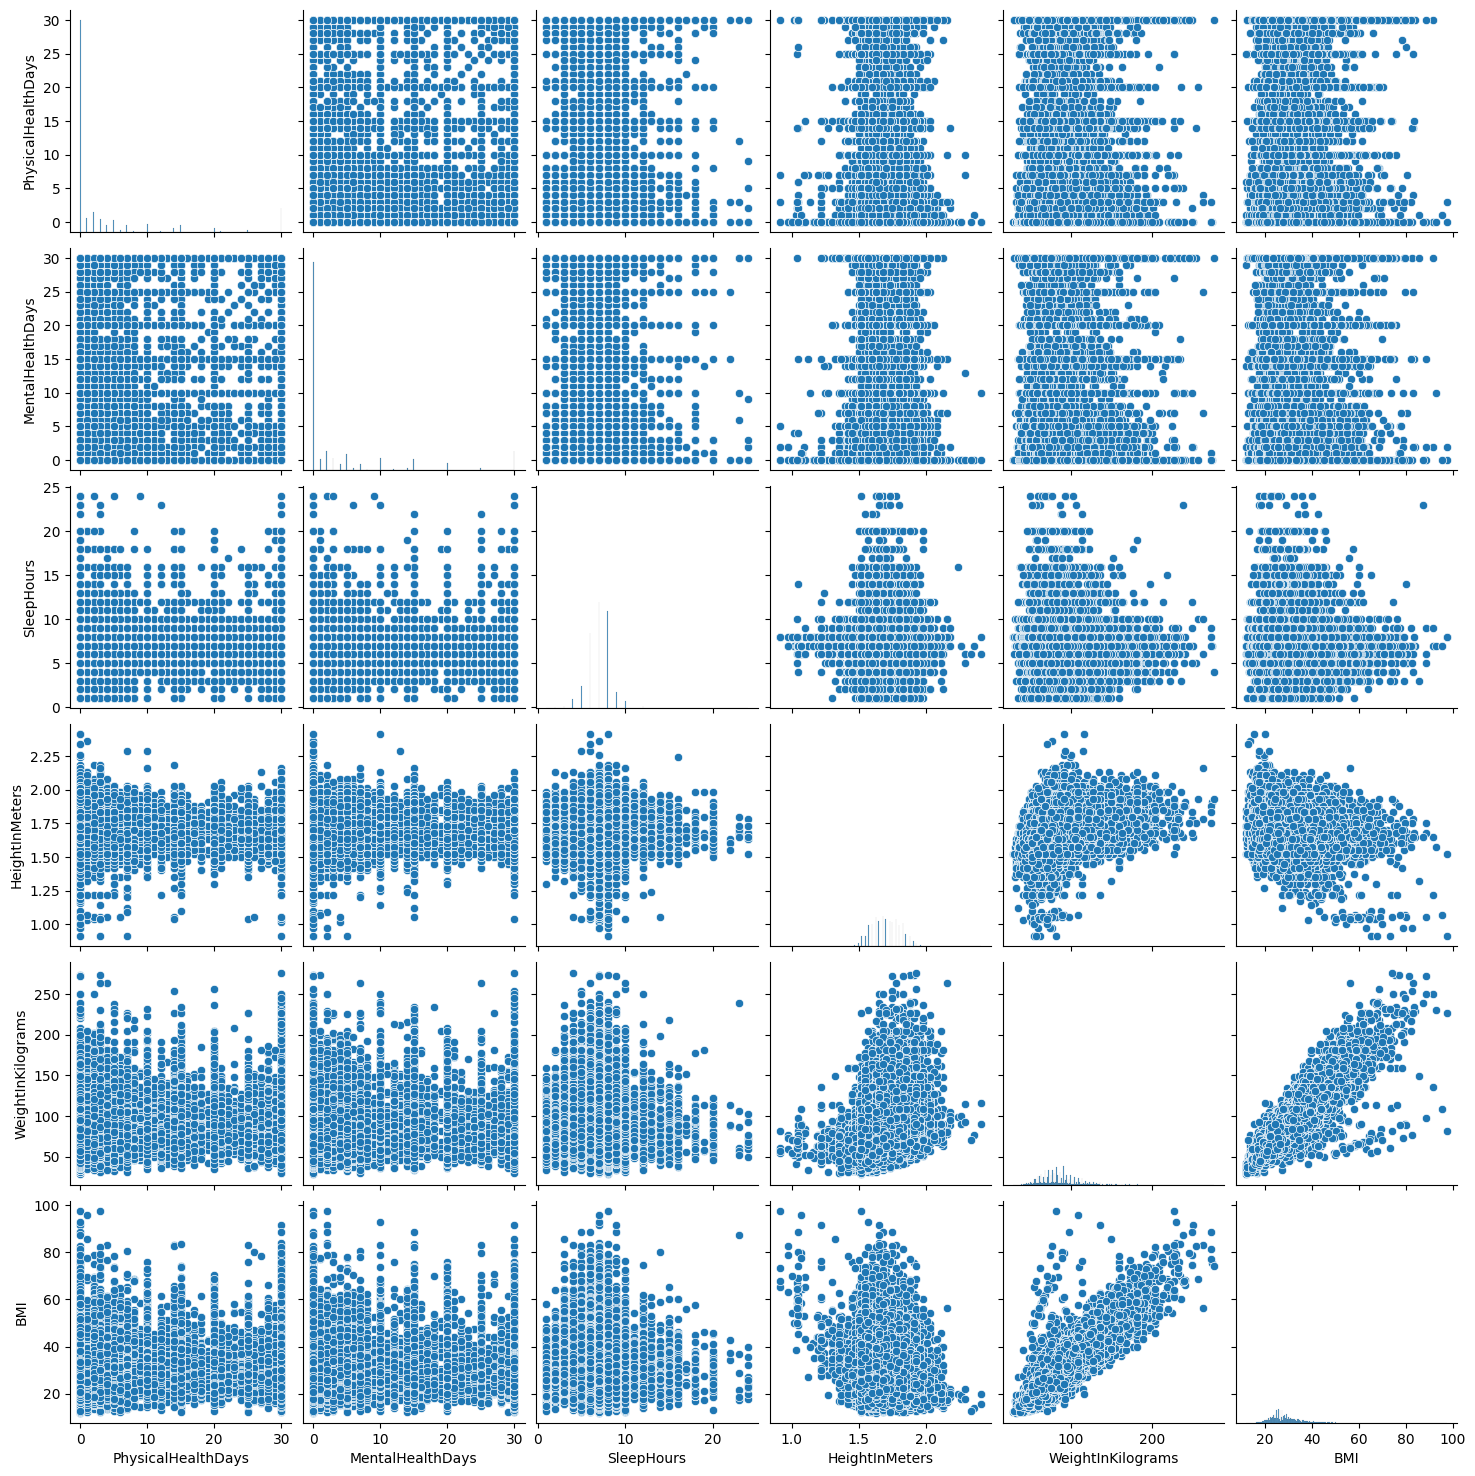

In [28]:
sns.pairplot(X_num)
plt.show()

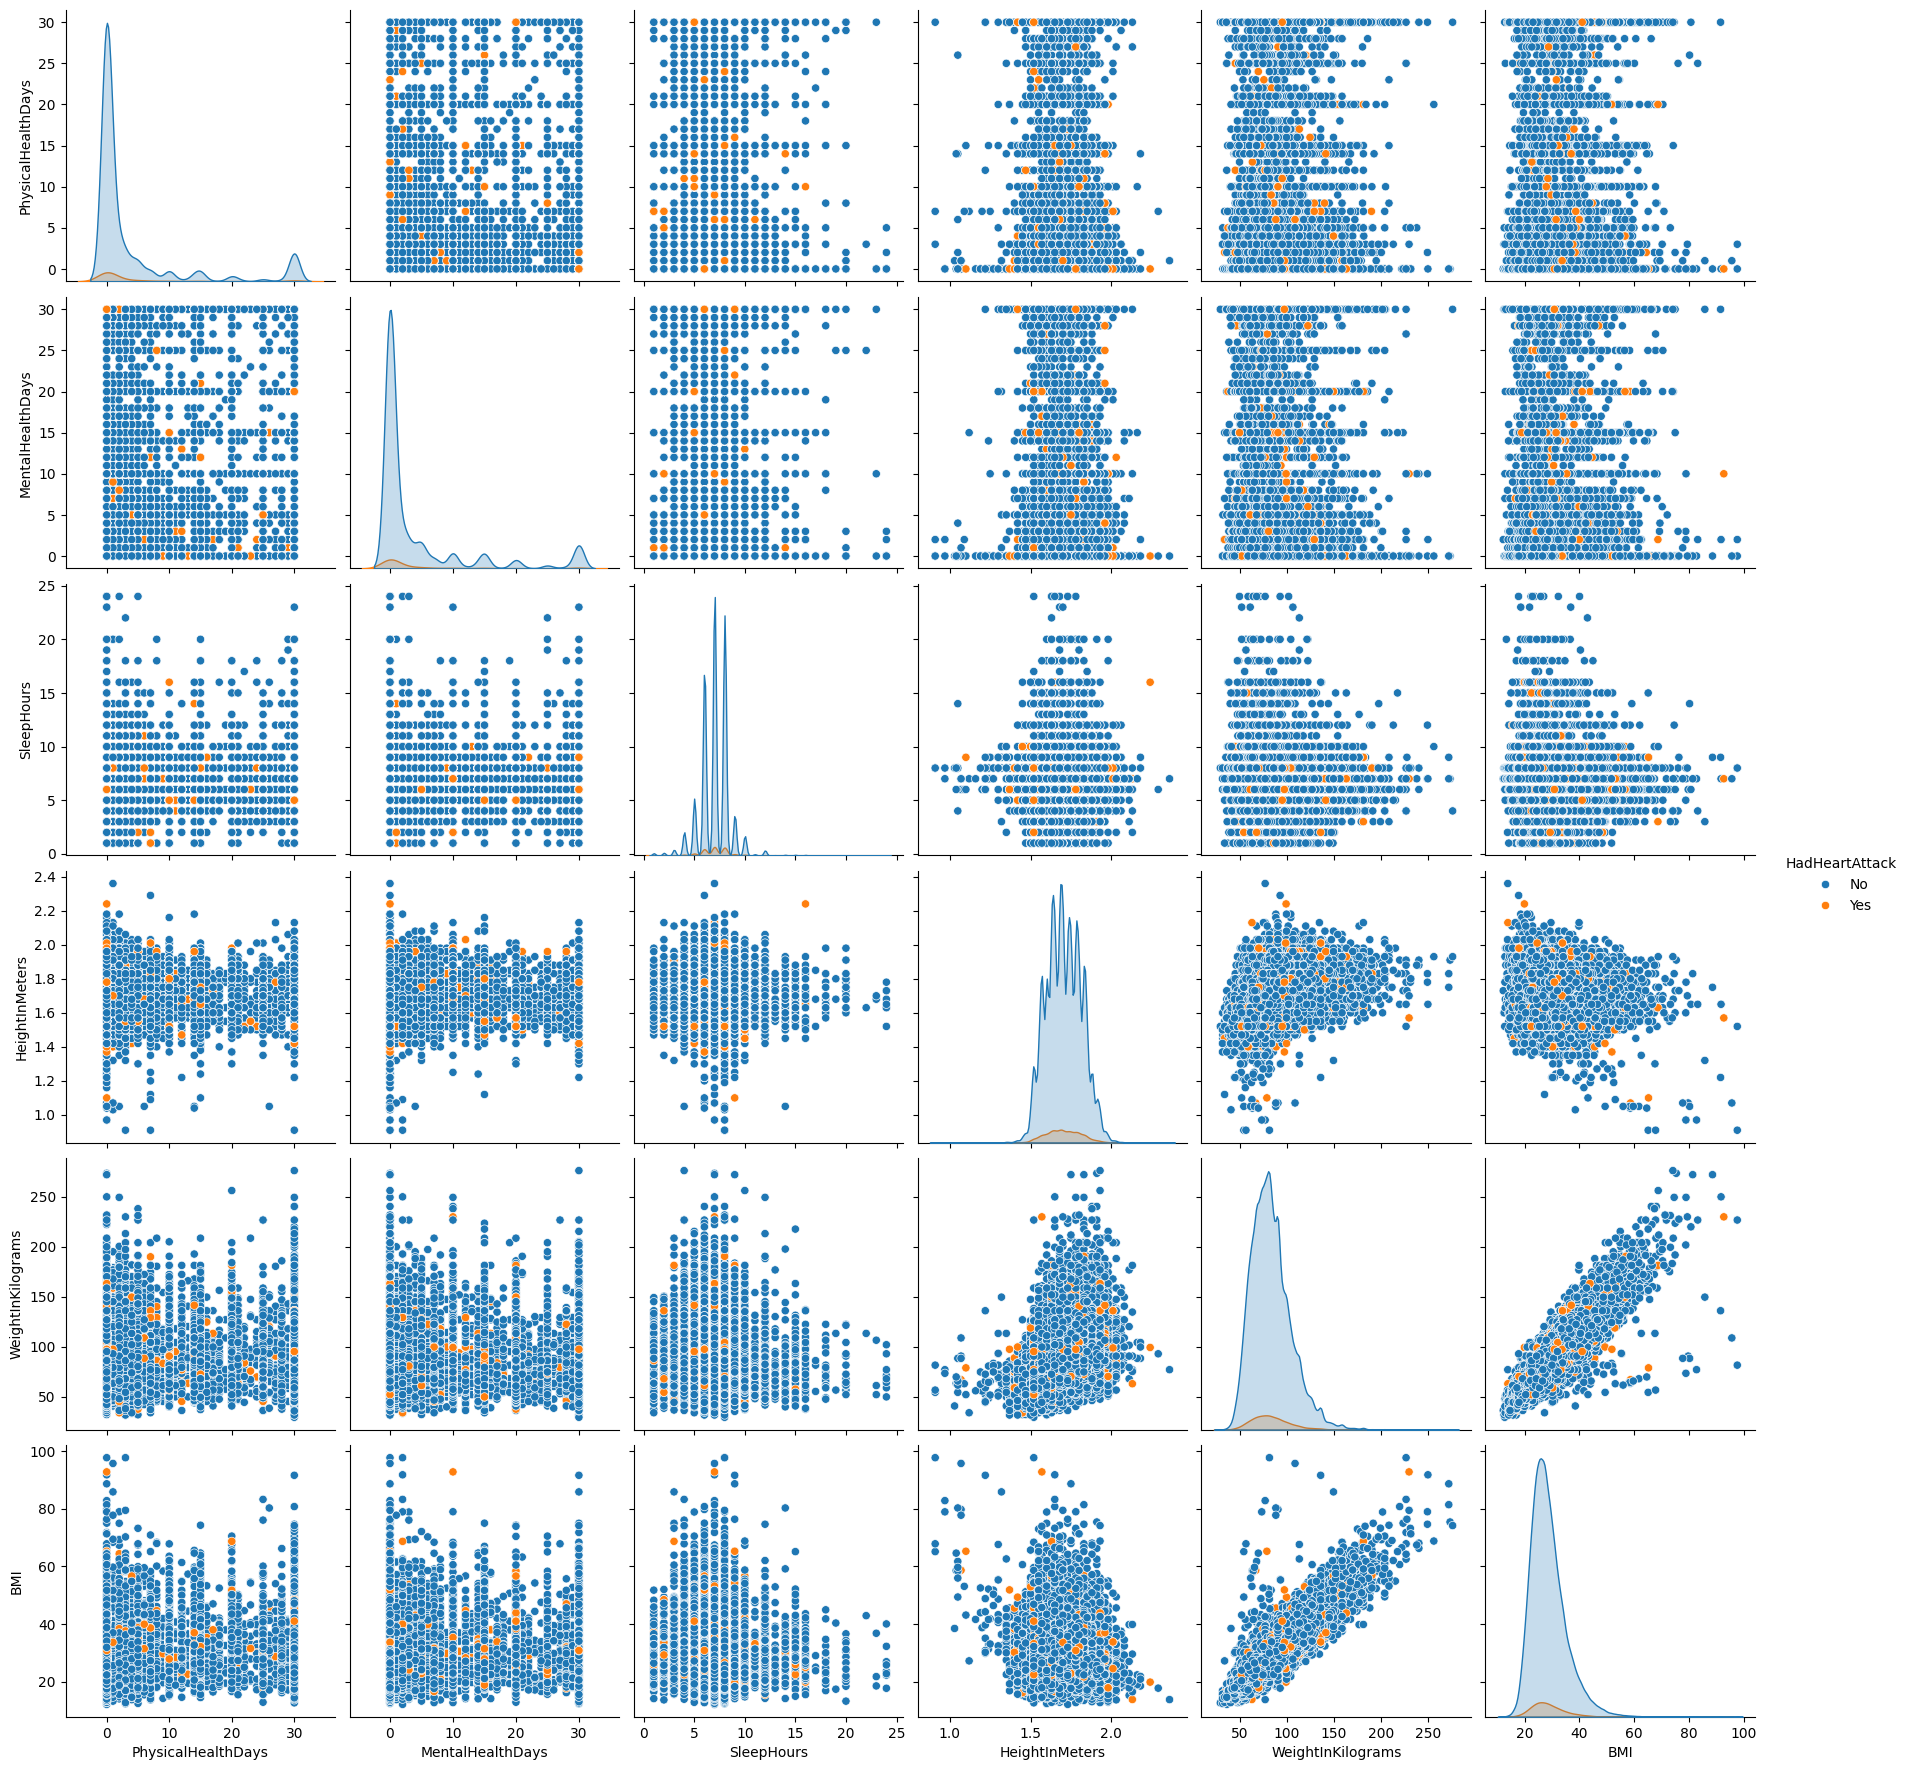

In [29]:
y_series = pd.Series(y_train, name='HadHeartAttack').astype(int)
target_mapping = {0: 'No', 1: 'Yes'}
y_series_mapped = y_series.map(target_mapping)

df_pair = X_num.join(y_series_mapped)
sns.pairplot(df_pair, hue='HadHeartAttack', height=3)
plt.show()

# idk

In [30]:
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
all_features = X.columns.tolist()

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale numeric columns in-place
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("Nulls in X_train_scaled (total):", X_train_scaled.isna().sum().sum())
print("Nulls in X_test_scaled (total):", X_test_scaled.isna().sum().sum())

X_train_scaled shape: (196817, 39)
X_test_scaled shape: (49205, 39)
Nulls in X_train_scaled (total): 0
Nulls in X_test_scaled (total): 0


In [31]:
X_train_scaled.head()

State       Sex  GeneralHealth  PhysicalHealthDays  \
287809  0.547016  1.039998      -0.872112           -0.489828   
306265  0.611676 -0.961540      -0.193563           -0.489828   
3666   -1.780723  1.039998      -0.193563            0.700668   
245526  0.223719  1.039998      -0.193563           -0.489828   
28483  -1.522085  1.039998      -0.193563            0.105420   

        MentalHealthDays  LastCheckupTime  PhysicalActivities  SleepHours  \
287809         -0.513834         0.453597           -1.870639    0.678899   
306265         -0.513834         0.453597           -1.870639   -0.711566   
3666            0.103952        -1.958672            0.534577   -0.711566   
245526          0.103952         0.453597            0.534577   -0.016334   
28483          -0.513834         0.453597            0.534577    0.678899   

        RemovedTeeth  HadAngina  ...  HeightInMeters  WeightInKilograms  \
287809      0.872625   3.925858  ...        0.701731          -0.837338   
306265     -0.608397  -0.254721  ...       -0.048084          -0.943804   
3666       -1.348908  -0.254721  ...       -0.516719          -0.837338   
245526     -1.348908  -0.254721  ...       -0.048084           0.971188   
28483      -1.348908   3.925858  ...        0.420550           0.013457   

             BMI  AlcoholDrinkers  HIVTesting  FluVaxLast12  PneumoVaxEver  \
287809 -1.207668        -1.105538   -0.722819      0.934919       1.210138   
306265 -1.035607        -1.105538   -0.722819     -1.069612       1.210138   
3666   -0.697628        -1.105538   -0.722819      0.934919       1.210138   
245526  1.128991         0.904537   -0.722819      0.934919       1.210138   
28483  -0.207560        -1.105538   -0.722819      0.934919       1.210138   

        TetanusLast10Tdap  HighRiskLastYear  CovidPos  
287809          -1.166370         -0.211118 -0.671247  
306265          -0.134406         -0.211118 -0.671247  
3666            -0.134406         -0.211118  1.551902  
245526          -0.134406         -0.211118 -0.671247  
28483            0.897558         -0.211118  1.551902  

[5 rows x 39 columns]

In [32]:
X_train_scaled.describe()

State           Sex  GeneralHealth  PhysicalHealthDays  \
count  1.968170e+05  1.968170e+05   1.968170e+05        1.968170e+05   
mean  -3.321356e-18  4.274441e-17  -5.371932e-17       -2.570441e-17   
std    1.000003e+00  1.000003e+00   1.000003e+00        1.000003e+00   
min   -1.780723e+00 -9.615402e-01  -1.550661e+00       -4.898280e-01   
25%   -8.108317e-01 -9.615402e-01  -8.721121e-01       -4.898280e-01   
50%   -3.491866e-02 -9.615402e-01  -1.935629e-01       -4.898280e-01   
75%    9.349726e-01  1.039998e+00   1.163536e+00       -1.326792e-01   
max    1.646226e+00  1.039998e+00   1.163536e+00        3.081660e+00   

       MentalHealthDays  LastCheckupTime  PhysicalActivities    SleepHours  \
count      1.968170e+05     1.968170e+05        1.968170e+05  1.968170e+05   
mean      -3.234712e-17     1.423851e-16        8.245627e-17  1.530712e-16   
std        1.000003e+00     1.000003e+00        1.000003e+00  1.000003e+00   
min       -5.138344e-01    -3.164807e+00       -1.870639e+00 -4.187727e+00   
25%       -5.138344e-01     4.535974e-01        5.345766e-01 -7.115659e-01   
50%       -5.138344e-01     4.535974e-01        5.345766e-01 -1.633372e-02   
75%       -1.960548e-02     4.535974e-01        5.345766e-01  6.788985e-01   
max        3.192882e+00     4.535974e-01        5.345766e-01  1.180261e+01   

       RemovedTeeth     HadAngina  ...  HeightInMeters  WeightInKilograms  \
count  1.968170e+05  1.968170e+05  ...    1.968170e+05       1.968170e+05   
mean   4.592136e-17  2.245525e-17  ...   -7.829375e-16      -4.386356e-17   
std    1.000003e+00  1.000003e+00  ...    1.000003e+00       1.000003e+00   
min   -1.348908e+00 -2.547214e-01  ...   -7.452513e+00      -2.603183e+00   
25%   -1.348908e+00 -2.547214e-01  ...   -7.041729e-01      -7.308711e-01   
50%    8.726254e-01 -2.547214e-01  ...   -4.808425e-02      -9.254029e-02   
75%    8.726254e-01 -2.547214e-01  ...    7.017313e-01       5.453215e-01   
max    8.726254e-01  3.925858e+00  ...    6.606529e+00       9.034042e+00   

                BMI  AlcoholDrinkers    HIVTesting  FluVaxLast12  \
count  1.968170e+05     1.968170e+05  1.968170e+05  1.968170e+05   
mean  -4.115593e-18     6.061475e-17  9.790780e-17 -7.090373e-17   
std    1.000003e+00     1.000003e+00  1.000003e+00  1.000003e+00   
min   -2.558045e+00    -1.105538e+00 -7.228192e-01 -1.069612e+00   
25%   -6.761207e-01    -1.105538e+00 -7.228192e-01 -1.069612e+00   
50%   -1.860521e-01     9.045373e-01 -7.228192e-01  9.349186e-01   
75%    4.945134e-01     9.045373e-01  1.383472e+00  9.349186e-01   
max    1.059699e+01     9.045373e-01  1.383472e+00  9.349186e-01   

       PneumoVaxEver  TetanusLast10Tdap  HighRiskLastYear      CovidPos  
count   1.968170e+05       1.968170e+05      1.968170e+05  1.968170e+05  
mean    1.249119e-16       3.581288e-17     -5.527170e-17 -6.296136e-17  
std     1.000003e+00       1.000003e+00      1.000003e+00  1.000003e+00  
min    -8.263524e-01      -1.166370e+00     -2.111182e-01 -6.712474e-01  
25%    -8.263524e-01      -1.166370e+00     -2.111182e-01 -6.712474e-01  
50%    -8.263524e-01      -1.344059e-01     -2.111182e-01 -6.712474e-01  
75%     1.210138e+00       8.975583e-01     -2.111182e-01  1.551902e+00  
max     1.210138e+00       1.929522e+00      4.736684e+00  1.551902e+00  

[8 rows x 39 columns]

In [33]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196817 entries, 287809 to 305759
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      196817 non-null  float64
 1   Sex                        196817 non-null  float64
 2   GeneralHealth              196817 non-null  float64
 3   PhysicalHealthDays         196817 non-null  float64
 4   MentalHealthDays           196817 non-null  float64
 5   LastCheckupTime            196817 non-null  float64
 6   PhysicalActivities         196817 non-null  float64
 7   SleepHours                 196817 non-null  float64
 8   RemovedTeeth               196817 non-null  float64
 9   HadAngina                  196817 non-null  float64
 10  HadStroke                  196817 non-null  float64
 11  HadAsthma                  196817 non-null  float64
 12  HadSkinCancer              196817 non-null  float64
 13  HadCOPD                    19

In [34]:
X_test_scaled.head()

State       Sex  GeneralHealth  PhysicalHealthDays  \
174348 -0.358216 -0.961540      -0.193563           -0.132679   
309927  0.676335  1.039998      -0.193563           -0.489828   
306766  0.611676 -0.961540      -1.550661           -0.489828   
98779  -0.940151 -0.961540      -0.193563            3.081660   
92845  -1.004810  1.039998       1.163536           -0.251729   

        MentalHealthDays  LastCheckupTime  PhysicalActivities  SleepHours  \
174348         -0.390277         0.453597            0.534577    1.374131   
309927         -0.513834         0.453597           -1.870639    0.678899   
306766         -0.513834        -1.958672            0.534577    0.678899   
98779          -0.513834         0.453597           -1.870639    0.678899   
92845          -0.513834         0.453597           -1.870639    0.678899   

        RemovedTeeth  HadAngina  ...  HeightInMeters  WeightInKilograms  \
174348      0.872625   3.925858  ...       -1.266535          -0.050329   
309927     -1.348908  -0.254721  ...       -0.704173           0.758255   
306766      0.872625  -0.254721  ...        0.233097          -0.837338   
98779       0.872625  -0.254721  ...       -1.266535           1.396586   
92845      -1.348908  -0.254721  ...        0.701731           1.821983   

             BMI  AlcoholDrinkers  HIVTesting  FluVaxLast12  PneumoVaxEver  \
174348  0.709590         0.904537   -0.722819      0.934919      -0.826352   
309927  1.396301        -1.105538   -0.722819     -1.069612      -0.826352   
306766 -1.017172        -1.105538   -0.722819     -1.069612      -0.826352   
98779   2.620704        -1.105538   -0.722819      0.934919       1.210138   
92845   1.546855         0.904537   -0.722819     -1.069612      -0.826352   

        TetanusLast10Tdap  HighRiskLastYear  CovidPos  
174348          -1.166370         -0.211118 -0.671247  
309927           0.897558         -0.211118 -0.671247  
306766           1.929522         -0.211118  1.551902  
98779            1.929522         -0.211118  1.551902  
92845            0.897558         -0.211118  1.551902  

[5 rows x 39 columns]

In [35]:
X_test_scaled.describe()

State           Sex  GeneralHealth  PhysicalHealthDays  \
count  49205.000000  49205.000000   49205.000000        49205.000000   
mean      -0.003441      0.000890      -0.006360            0.002702   
std        1.000150      1.000045       1.000441            1.003554   
min       -1.780723     -0.961540      -1.550661           -0.489828   
25%       -0.810832     -0.961540      -0.872112           -0.489828   
50%       -0.099578     -0.961540      -0.193563           -0.489828   
75%        0.934973      1.039998       1.163536           -0.132679   
max        1.646226      1.039998       1.163536            3.081660   

       MentalHealthDays  LastCheckupTime  PhysicalActivities    SleepHours  \
count      49205.000000     49205.000000        49205.000000  49205.000000   
mean           0.005229        -0.009050           -0.001165     -0.007517   
std            1.005704         1.008004            1.000787      1.007993   
min           -0.513834        -3.164807           -1.870639     -4.187727   
25%           -0.513834         0.453597            0.534577     -0.711566   
50%           -0.513834         0.453597            0.534577     -0.016334   
75%           -0.019605         0.453597            0.534577      0.678899   
max            3.192882         0.453597            0.534577     11.802614   

       RemovedTeeth     HadAngina  ...  HeightInMeters  WeightInKilograms  \
count  49205.000000  49205.000000  ...    49205.000000       49205.000000   
mean       0.001966     -0.003147  ...        0.000946          -0.001851   
std        0.999522      0.994211  ...        0.998178           1.000449   
min       -1.348908     -0.254721  ...       -7.452513          -2.475611   
25%       -1.348908     -0.254721  ...       -0.704173          -0.730871   
50%        0.872625     -0.254721  ...       -0.048084          -0.092540   
75%        0.872625     -0.254721  ...        0.701731           0.545322   
max        0.872625      3.925858  ...        5.200625           9.799946   

                BMI  AlcoholDrinkers    HIVTesting  FluVaxLast12  \
count  49205.000000     49205.000000  49205.000000  49205.000000   
mean      -0.002252        -0.000190      0.003178     -0.003286   
std        1.003588         1.000029      1.001054      1.000226   
min       -2.553437        -1.105538     -0.722819     -1.069612   
25%       -0.685338        -1.105538     -0.722819     -1.069612   
50%       -0.189125         0.904537     -0.722819      0.934919   
75%        0.491441         0.904537      1.383472      0.934919   
max       10.596993         0.904537      1.383472      0.934919   

       PneumoVaxEver  TetanusLast10Tdap  HighRiskLastYear      CovidPos  
count   49205.000000       49205.000000      49205.000000  49205.000000  
mean        0.002605           0.001456          0.007890      0.010720  
std         1.000507           1.001493          1.017677      1.003575  
min        -0.826352          -1.166370         -0.211118     -0.671247  
25%        -0.826352          -1.166370         -0.211118     -0.671247  
50%        -0.826352          -0.134406         -0.211118     -0.671247  
75%         1.210138           0.897558         -0.211118      1.551902  
max         1.210138           1.929522          4.736684      1.551902  

[8 rows x 39 columns]

In [36]:
X_test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49205 entries, 174348 to 132913
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   State                      49205 non-null  float64
 1   Sex                        49205 non-null  float64
 2   GeneralHealth              49205 non-null  float64
 3   PhysicalHealthDays         49205 non-null  float64
 4   MentalHealthDays           49205 non-null  float64
 5   LastCheckupTime            49205 non-null  float64
 6   PhysicalActivities         49205 non-null  float64
 7   SleepHours                 49205 non-null  float64
 8   RemovedTeeth               49205 non-null  float64
 9   HadAngina                  49205 non-null  float64
 10  HadStroke                  49205 non-null  float64
 11  HadAsthma                  49205 non-null  float64
 12  HadSkinCancer              49205 non-null  float64
 13  HadCOPD                    49205 non-null  fl

In [37]:
X_train_np = X_train_scaled.values.astype(np.float32)
X_test_np  = X_test_scaled.values.astype(np.float32)

y_train_np = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)
y_test_np  = np.asarray(y_test, dtype=np.float32).reshape(-1, 1)

num_features = X_train_np.shape[1]
print("num_features:", num_features, "| X_train shape:", X_train_np.shape)

tf.random.set_seed(42)

# Compute class weights for imbalance
classes = np.unique(y_train_np.ravel().astype(int))
cw = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_np.ravel().astype(int),
)
class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
print("Class weights:", class_weights)

def build_model(input_dim: int) -> tf.keras.Model:
    inputs = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs, name="heart_attack_mlp")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc", curve="ROC"),
            tf.keras.metrics.AUC(name="prc", curve="PR"),
        ],
    )
    return model

mlp_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=5, verbose=1),
]

num_features: 39 | X_train shape: (196817, 39)
Class weights: {0: 0.5288817589173909, 1: 9.15598250837365}


In [38]:
base_models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "LinearSVM": LinearSVC(max_iter=5000, tol=1e-4, class_weight='balanced', dual=False, random_state=42),
    "SGD_SVM": SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, penalty='l2', alpha=1e-4, random_state=42),
    "NaiveBayes": GaussianNB(),
}

def create_keras_model():
    return build_model(num_features)

# Add the UNFITTED SciKeras wrapper to base_models
base_models["KerasMLP"] = KerasClassifier(
    model=create_keras_model,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=mlp_callbacks,
    verbose=0,  # Set to 1 if you want to see training progress
)

bagging_models = {
    "Bagging_DT": BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=50, random_state=42, n_jobs=-1
    ),
    "Bagging_LR": BaggingClassifier(
        estimator=LogisticRegression(max_iter=1000, random_state=42),
        n_estimators=50, random_state=42, n_jobs=-1
    ),
    "Bagging_LinearSVM": BaggingClassifier(
        estimator=LinearSVC(max_iter=2000, dual=False, random_state=42),
        n_estimators=30, random_state=42, n_jobs=-1
    )
}

boosting_models = {
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(iterations=100, random_state=42, verbose=0)
}

voting_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ],
    voting='soft'
)

stacking_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('dt', DecisionTreeClassifier(random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5
)

ensemble_models = {
    **bagging_models,
    **boosting_models,
    "VotingClassifier": voting_model,
    "StackingClassifier": stacking_model
}


In [39]:
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols)],
    remainder="passthrough"
)

### MLP (Fully Connected Network)


EVALUATING BASE MODELS WITH CROSS-VALIDATION

Running model: LogisticRegression


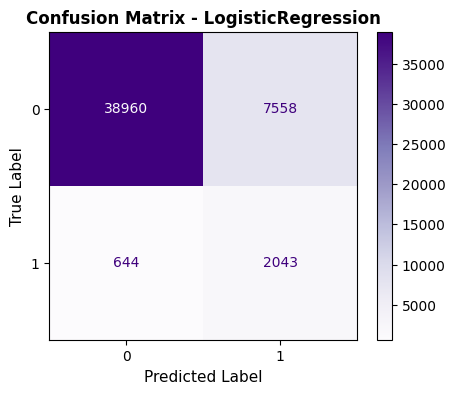

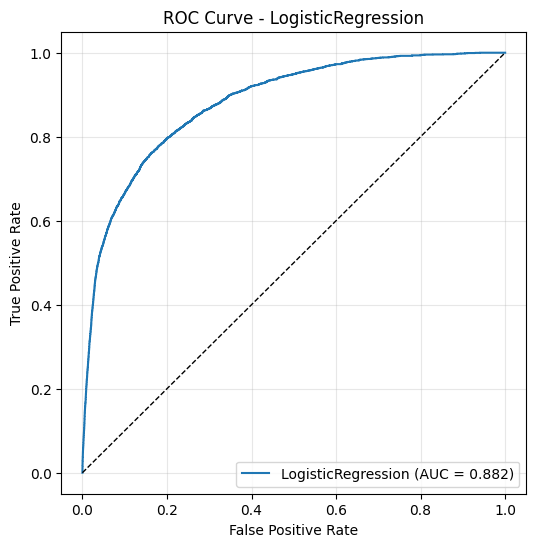

LogisticRegression        | CV AUC: 0.8869 (±0.0024) | Test AUC: 0.8823 | Acc: 0.8333 | F1: 0.3325 | MSE: 0.1667 | LogLoss: 0.4240

Running model: RandomForest


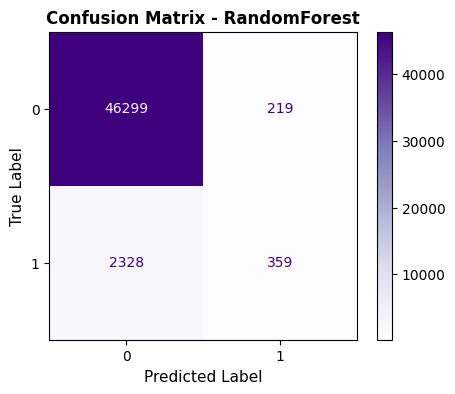

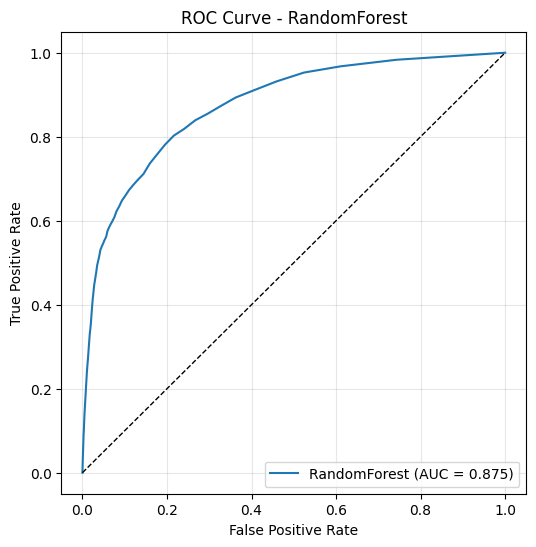

RandomForest              | CV AUC: 0.8787 (±0.0029) | Test AUC: 0.8750 | Acc: 0.9482 | F1: 0.2199 | MSE: 0.0518 | LogLoss: 0.1576

Running model: DecisionTree


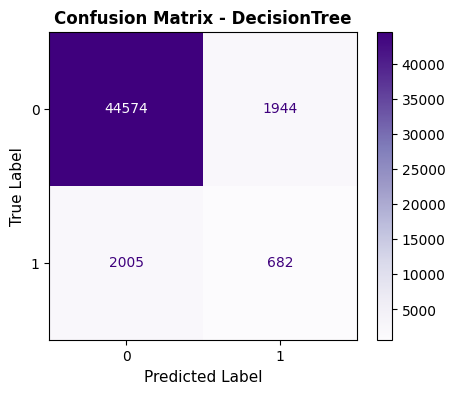

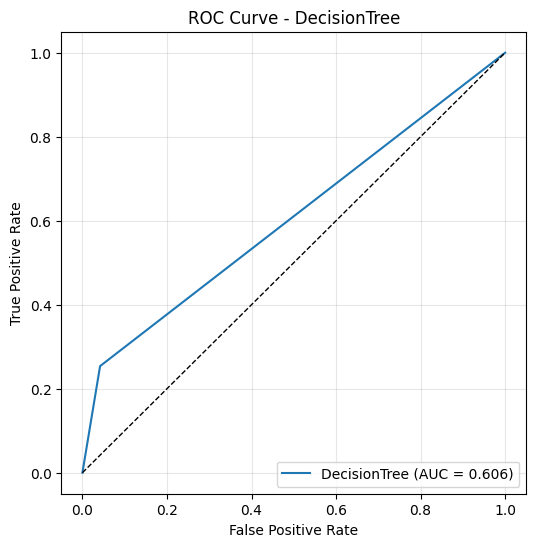

DecisionTree              | CV AUC: 0.6086 (±0.0039) | Test AUC: 0.6060 | Acc: 0.9197 | F1: 0.2567 | MSE: 0.0803 | LogLoss: 1.2936

Running model: LinearSVM


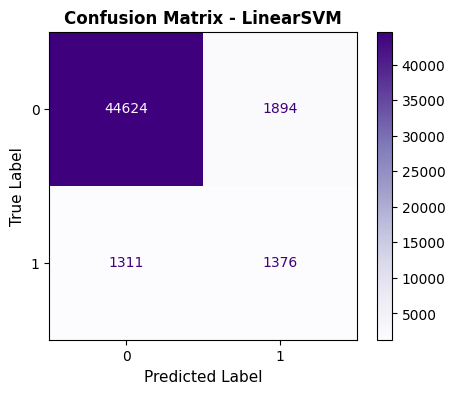

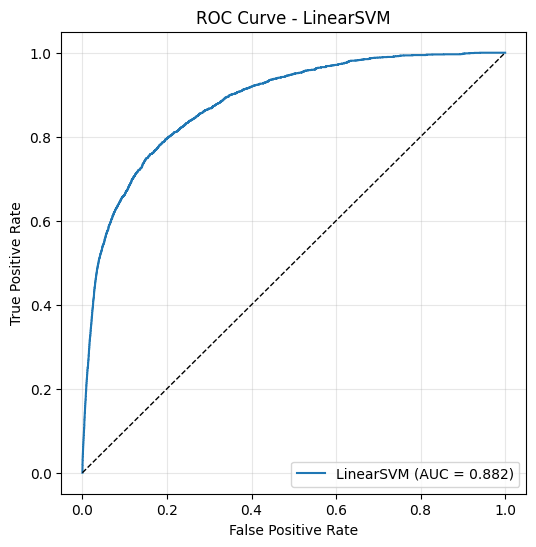

LinearSVM                 | CV AUC: 0.8869 (±0.0023) | Test AUC: 0.8821 | Acc: 0.9349 | F1: 0.4620 | MSE: 0.0651 | LogLoss: 0.5136

Running model: SGD_SVM


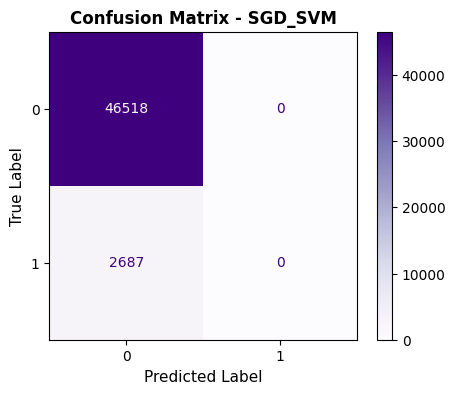

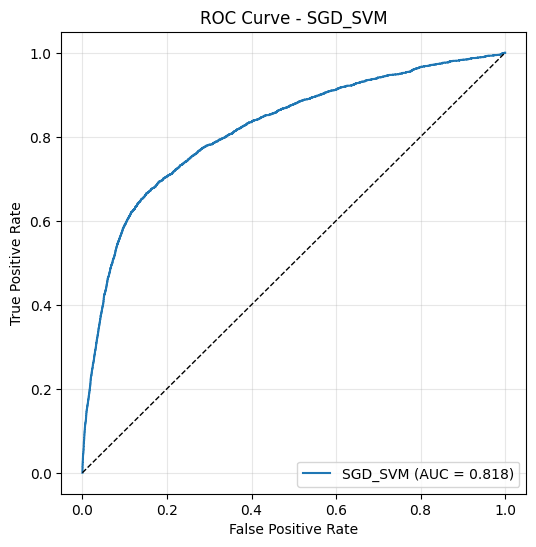

SGD_SVM                   | CV AUC: 0.8158 (±0.0191) | Test AUC: 0.8184 | Acc: 0.9454 | F1: 0.0000 | MSE: 0.0546 | LogLoss: 0.8797

Running model: NaiveBayes


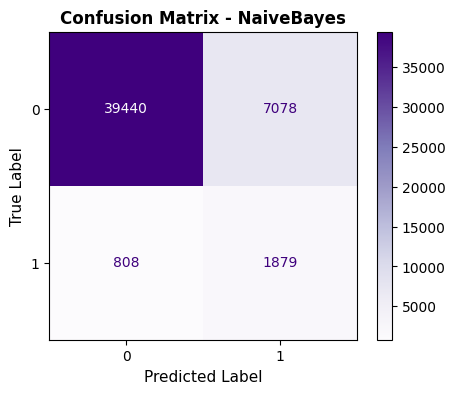

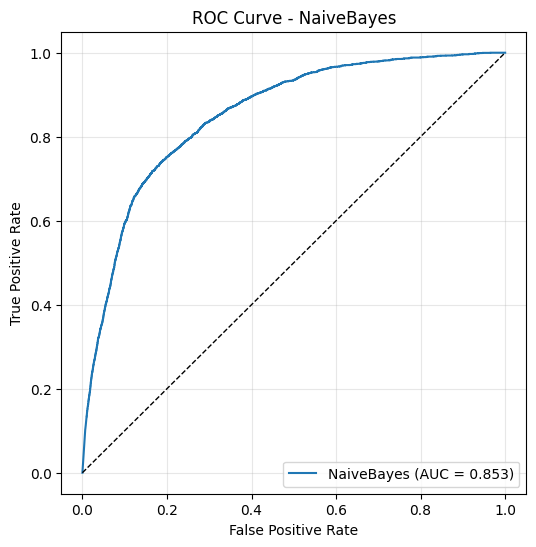

NaiveBayes                | CV AUC: 0.8577 (±0.0024) | Test AUC: 0.8531 | Acc: 0.8397 | F1: 0.3227 | MSE: 0.1603 | LogLoss: 1.3749

Running model: KerasMLP

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.


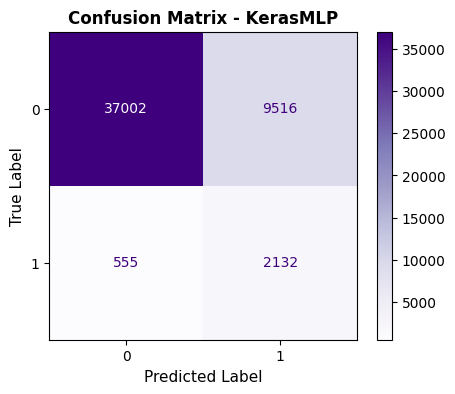

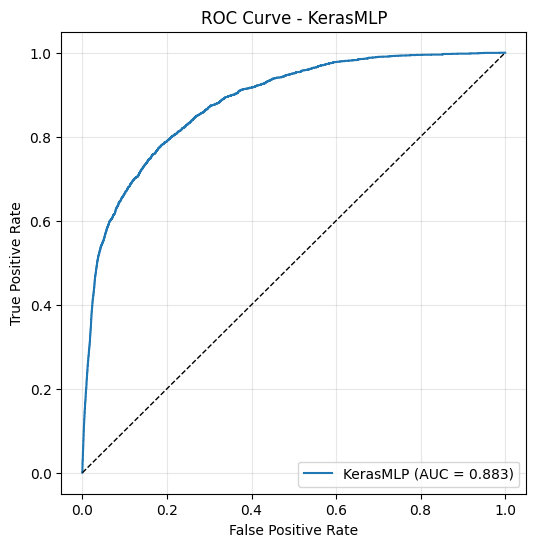

KerasMLP                  | CV AUC: nan (±nan) | Test AUC: 0.8827 | Acc: 0.7953 | F1: 0.2975 | MSE: 0.2047 | LogLoss: 0.4163

EVALUATING ENSEMBLE MODELS WITH CROSS-VALIDATION

Running model: Bagging_DT


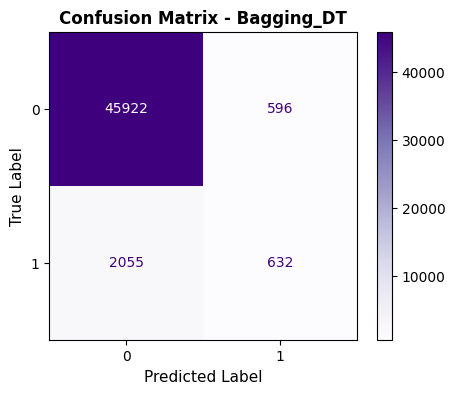

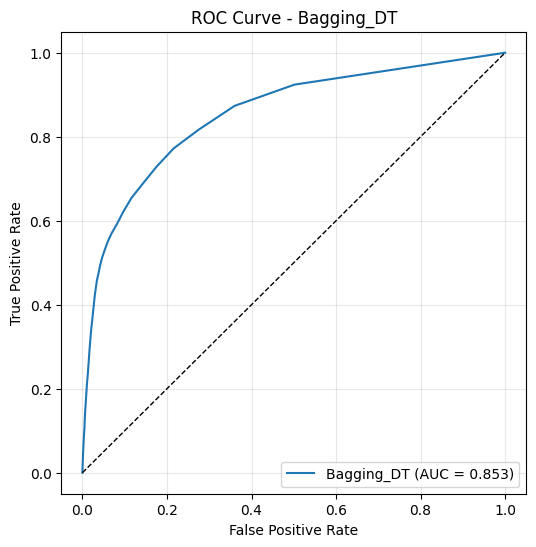

Bagging_DT                | CV AUC: 0.8563 (±0.0036) | Test AUC: 0.8534 | Acc: 0.9461 | F1: 0.3229 | MSE: 0.0539 | LogLoss: 0.2012

Running model: Bagging_LR


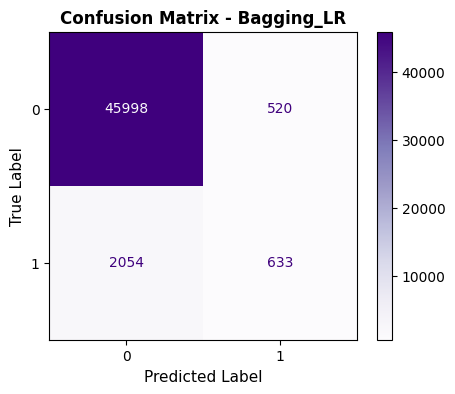

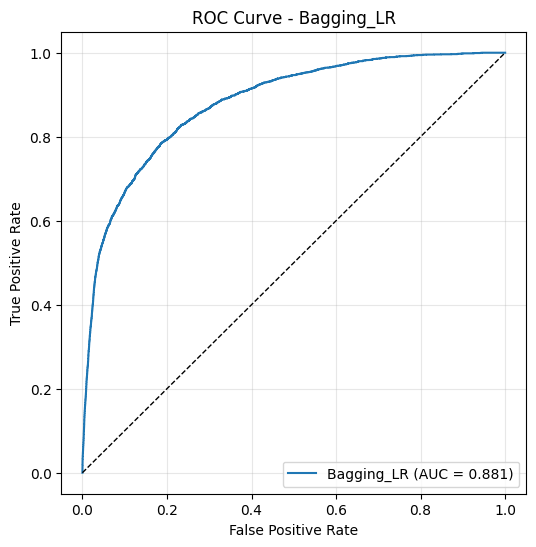

Bagging_LR                | CV AUC: 0.8864 (±0.0025) | Test AUC: 0.8814 | Acc: 0.9477 | F1: 0.3297 | MSE: 0.0523 | LogLoss: 0.1481

Running model: Bagging_LinearSVM


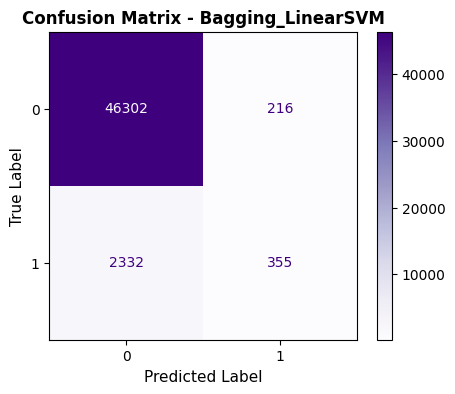

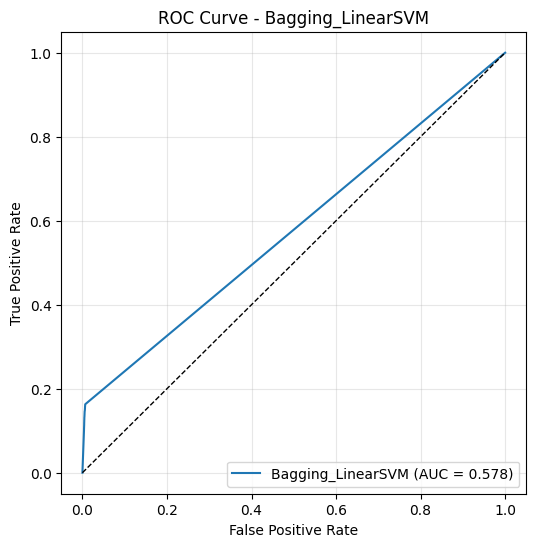

Bagging_LinearSVM         | CV AUC: 0.8855 (±0.0025) | Test AUC: 0.5782 | Acc: 0.9482 | F1: 0.2179 | MSE: 0.0518 | LogLoss: 0.7993

Running model: AdaBoost


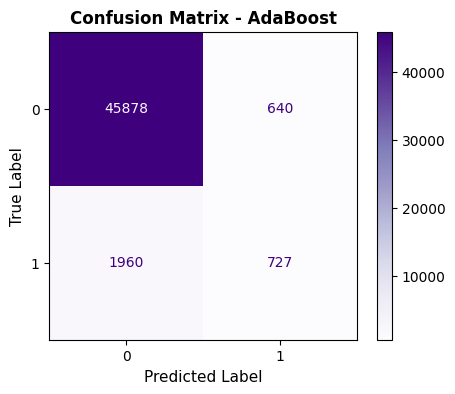

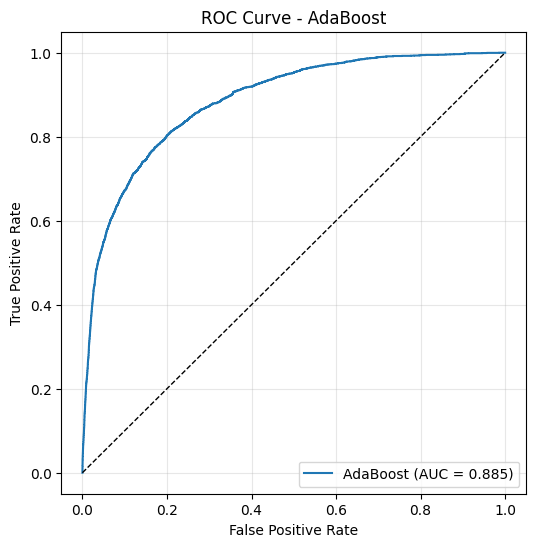

AdaBoost                  | CV AUC: 0.8879 (±0.0029) | Test AUC: 0.8850 | Acc: 0.9472 | F1: 0.3587 | MSE: 0.0528 | LogLoss: 0.4217

Running model: GradientBoosting


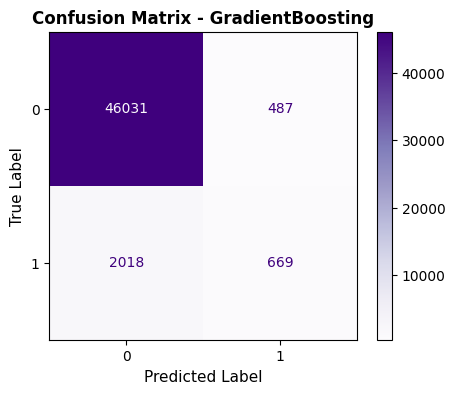

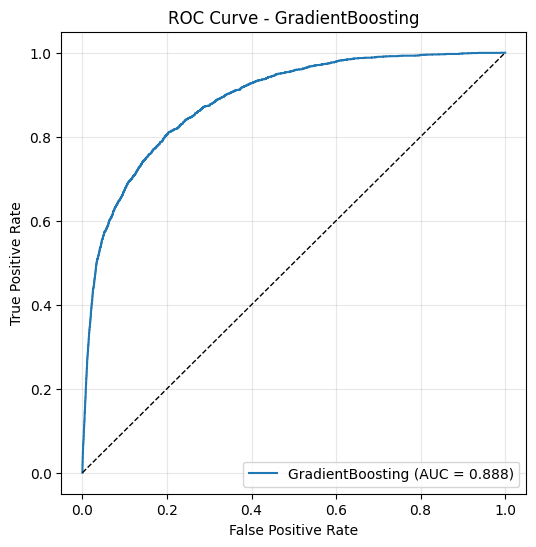

GradientBoosting          | CV AUC: 0.8911 (±0.0029) | Test AUC: 0.8879 | Acc: 0.9491 | F1: 0.3482 | MSE: 0.0509 | LogLoss: 0.1449

Running model: XGBoost


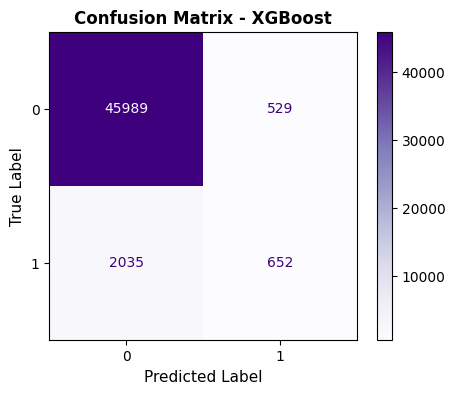

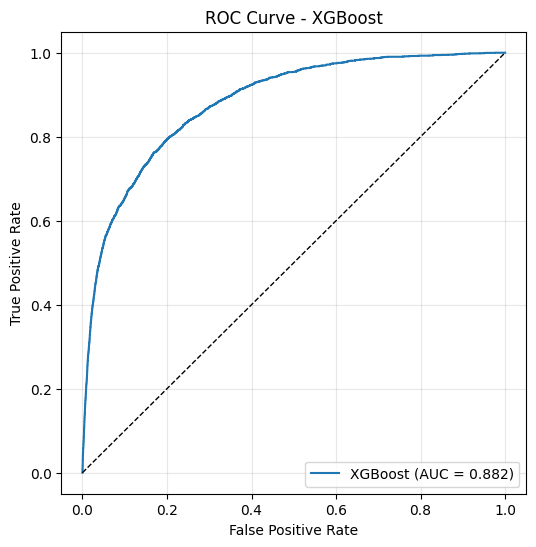

XGBoost                   | CV AUC: 0.8802 (±0.0031) | Test AUC: 0.8820 | Acc: 0.9479 | F1: 0.3371 | MSE: 0.0521 | LogLoss: 0.1489

Running model: CatBoost


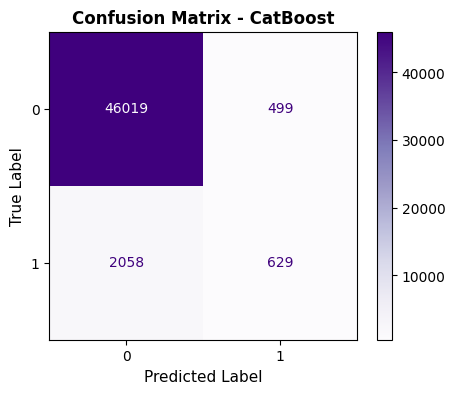

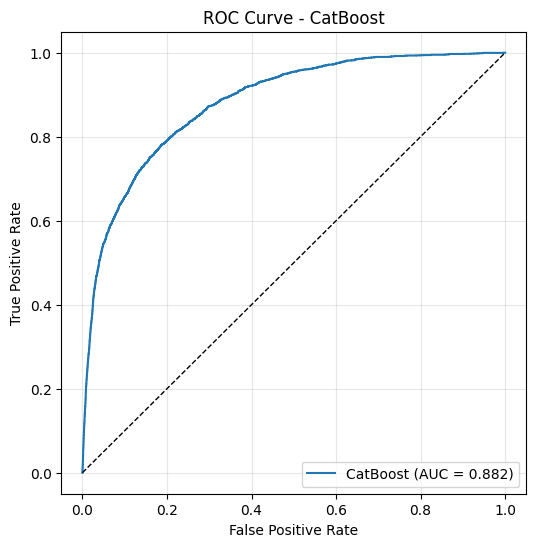

CatBoost                  | CV AUC: 0.8849 (±0.0032) | Test AUC: 0.8819 | Acc: 0.9480 | F1: 0.3298 | MSE: 0.0520 | LogLoss: 0.1489

Running model: VotingClassifier


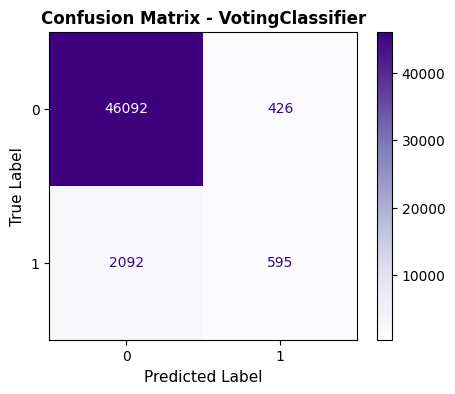

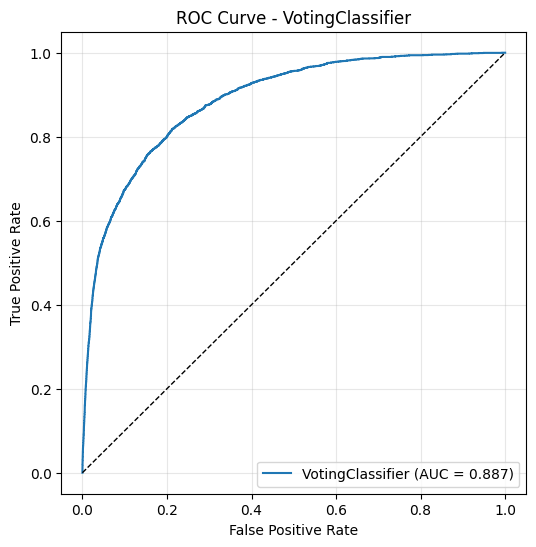

VotingClassifier          | CV AUC: 0.8883 (±0.0031) | Test AUC: 0.8873 | Acc: 0.9488 | F1: 0.3209 | MSE: 0.0512 | LogLoss: 0.1448

Running model: StackingClassifier


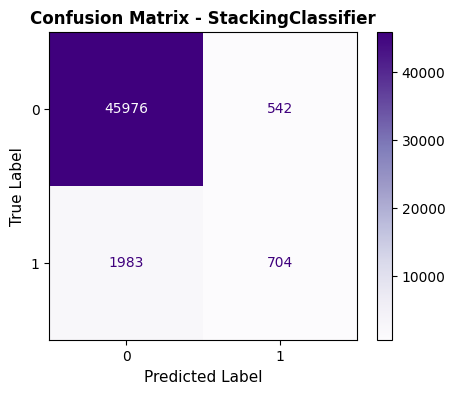

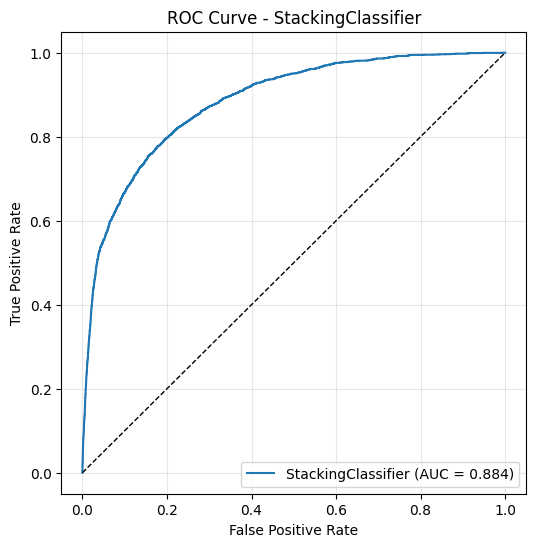

StackingClassifier        | CV AUC: 0.8853 (±0.0032) | Test AUC: 0.8839 | Acc: 0.9487 | F1: 0.3580 | MSE: 0.0513 | LogLoss: 0.1548

All Models Ranked by CV AUC:
             Model     Type  CV_AUC_Mean  CV_AUC_Std  Test_AUC  Test_Accuracy  Test_F1  Test_MSE  Test_LogLoss
  GradientBoosting Ensemble     0.891066    0.002855  0.887915       0.949091 0.348165  0.050909      0.144898
  VotingClassifier Ensemble     0.888316    0.003131  0.887348       0.948826 0.320928  0.051174      0.144777
          AdaBoost Ensemble     0.887860    0.002882  0.884976       0.947160 0.358658  0.052840      0.421739
         LinearSVM     Base     0.886930    0.002328  0.882101       0.934864 0.461978  0.065136      0.513555
LogisticRegression     Base     0.886907    0.002390  0.882282       0.833310 0.332520  0.166690      0.424006
        Bagging_LR Ensemble     0.886382    0.002511  0.881426       0.947688 0.329688  0.052312      0.148108
 Bagging_LinearSVM Ensemble     0.885484    0.002488  0.578223

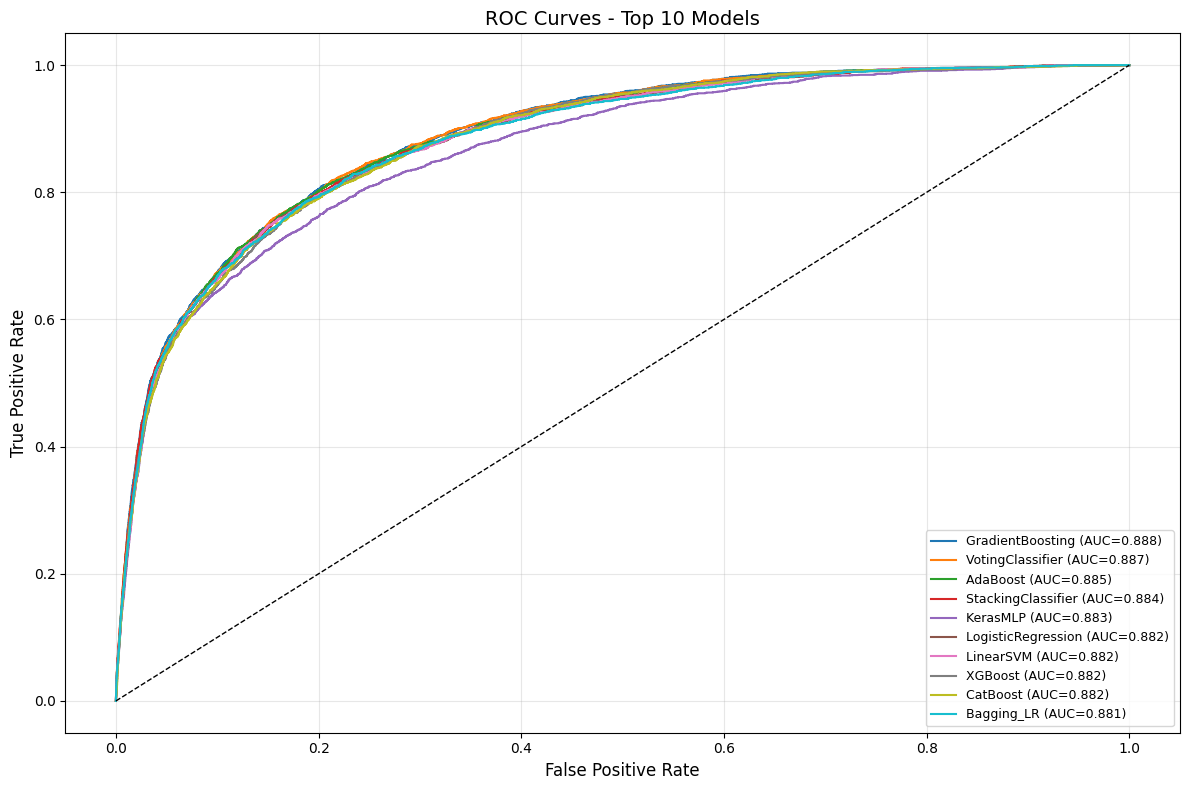

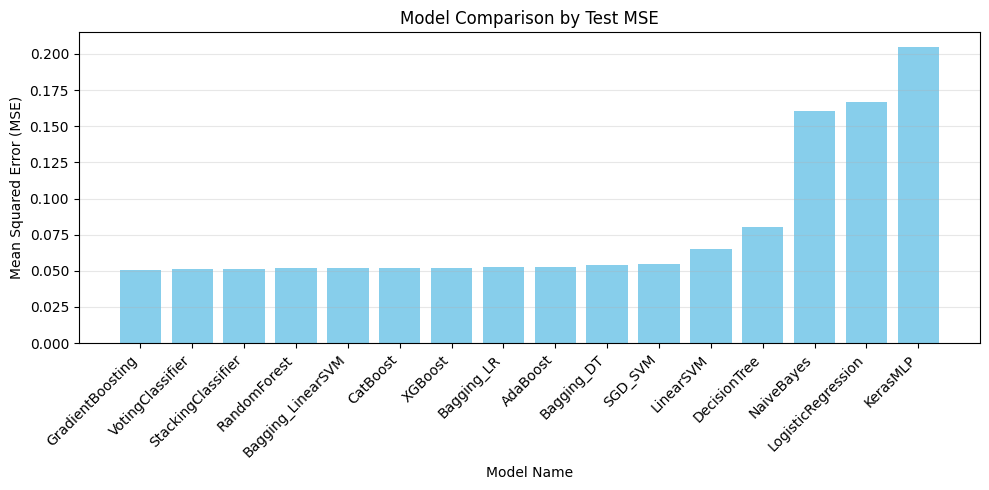

In [40]:
# Helper: Get probability or score for binary classifiers
def get_proba_or_score(estimator, X):
    try:
        if hasattr(estimator, "predict_proba"):
            proba = estimator.predict_proba(X)
            if proba.ndim == 2 and proba.shape[1] >= 2:
                return proba[:, 1]
            return proba.ravel()
        if hasattr(estimator, "decision_function"):
            return estimator.decision_function(X)
    except Exception:
        # fallback for SciKeras pipeline issues
        pred = estimator.predict(X)
        # if classification, map 0/1 to probability
        if pred.ndim == 1:
            return pred.astype(float)
        return pred


# Helper function to evaluate models (base or ensemble)
def evaluate_models(model_dict, model_type, X_train, y_train, X_test, y_test, preprocessor, cv_strategy):
    results = []
    print("\n" + "=" * 80)
    print(f"EVALUATING {model_type.upper()} MODELS WITH CROSS-VALIDATION")
    print("=" * 80)

    for name, model in model_dict.items():
        print(f"\nRunning model: {name}")
        
        try:
            # Special handling for SciKeras MLP
            if name == "KerasMLP":
                # Use pre-processed numpy arrays directly (no pipeline preprocessing)
                # Assuming X_train_np and X_test_np are already preprocessed
                model.fit(X_train_np, y_train_np.ravel(), class_weight=class_weights)
                
                # Get predictions
                y_proba = model.predict_proba(X_test_np)[:, 1]
                y_pred = (y_proba >= 0.5).astype(int)
                
                # No CV for KerasMLP (or implement custom CV if needed)
                cv_scores = np.array([np.nan])
                
            else:
                # Standard sklearn models with pipeline
                pipeline_eval = Pipeline([
                    ("preproc", preprocessor),
                    ("clf", model)
                ])
                
                cv_scores = cross_val_score(
                    pipeline_eval, X_train, y_train, cv=cv_strategy,
                    scoring='roc_auc', n_jobs=-1, error_score="raise"
                )
                pipeline_eval.fit(X_train, y_train)
                y_proba = get_proba_or_score(pipeline_eval, X_test)
                y_pred = (y_proba >= 0.5).astype(int) if y_proba.ndim == 1 else pipeline_eval.predict(X_test)
            
            # Compute metrics (same for both)
            test_auc = metrics.roc_auc_score(y_test, y_proba)
            test_acc = metrics.accuracy_score(y_test, y_pred)
            test_f1 = metrics.f1_score(y_test, y_pred, zero_division=0)
            test_mse = metrics.mean_squared_error(y_test, y_pred)
            test_logloss = metrics.log_loss(y_test, np.clip(y_proba, 1e-7, 1 - 1e-7))
            
            # Store results
            results.append({
                'Model': name,
                'Type': model_type,
                'CV_AUC_Mean': cv_scores.mean() if not np.isnan(cv_scores[0]) else None,
                'CV_AUC_Std': cv_scores.std() if not np.isnan(cv_scores[0]) else None,
                'Test_AUC': test_auc,
                'Test_Accuracy': test_acc,
                'Test_F1': test_f1,
                'Test_MSE': test_mse,
                'Test_LogLoss': test_logloss,
            })

            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            fig, ax = plt.subplots(figsize=(5, 4))
            disp.plot(cmap='Purples', ax=ax, colorbar=True)
            plt.title(f'Confusion Matrix - {name}', fontsize=12, weight='bold')
            plt.xlabel('Predicted Label', fontsize=11)
            plt.ylabel('True Label', fontsize=11)
            plt.grid(False)
            plt.show()

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            test_auc = auc(fpr, tpr)
            plt.figure(figsize=(6, 6))
            plt.plot(fpr, tpr, label=f"{name} (AUC = {test_auc:.3f})")
            plt.plot([0, 1], [0, 1], "k--", lw=1)
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve - {name}")
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)
            plt.show()
            print(f"{name:25s} | CV AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f}) | "
                f"Test AUC: {test_auc:.4f} | Acc: {test_acc:.4f} | F1: {test_f1:.4f} | "
                f"MSE: {test_mse:.4f} | LogLoss: {test_logloss:.4f}")

        except Exception as e:
            print(f"  ERROR running model {name} — skipping. Exception: {e}")

    return results


# ===========================
# MAIN EVALUATION PIPELINE
# ===========================
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_results = []

# Evaluate both sets of models using the same function
all_results.extend(evaluate_models(base_models, "Base", X_train, y_train, X_test, y_test, preprocessor, cv_strategy))
all_results.extend(evaluate_models(ensemble_models, "Ensemble", X_train, y_train, X_test, y_test, preprocessor, cv_strategy))

# Combine all results
results_df = pd.DataFrame(all_results)

print("\nAll Models Ranked by CV AUC:")
if not results_df.empty:
    print(results_df.sort_values('CV_AUC_Mean', ascending=False).to_string(index=False))
else:
    print("No successful model results.")

# ===========================
# BEST MODEL SELECTION
# ===========================


if not results_df.empty:
    # ===========================
    # ROC CURVE COMPARISON
    # ===========================
    plt.figure(figsize=(12, 8))
    top_10 = results_df.nlargest(10, 'Test_AUC')

    for _, row in top_10.iterrows():
        model_name = row['Model']
        model = (base_models.get(model_name) or ensemble_models.get(model_name))
        if model is None:
            continue
        pipe = Pipeline([("preproc", preprocessor), ("clf", model)])
        pipe.fit(X_train, y_train)
        y_proba = get_proba_or_score(pipe, X_test)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={row['Test_AUC']:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("ROC Curves - Top 10 Models", fontsize=14)
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ===========================
    # MSE COMPARISON PLOT
    # ===========================
    plt.figure(figsize=(10, 5))
    sorted_mse = results_df.sort_values("Test_MSE", ascending=True)
    plt.bar(sorted_mse["Model"], sorted_mse["Test_MSE"], color="skyblue")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Model Name")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("Model Comparison by Test MSE")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [41]:
best_model = None
if not results_df.empty:
    best_idx = results_df['Test_AUC'].idxmax()
    best_model_row = results_df.loc[best_idx]
    best_model_name = best_model_row['Model']

    print("\n" + "=" * 80)
    print("BEST MODEL")
    print("=" * 80)
    print(f"Model: {best_model_row['Model']}")
    print(f"Type: {best_model_row['Type']}")
    print(f"CV AUC: {best_model_row['CV_AUC_Mean']:.4f} (±{best_model_row['CV_AUC_Std']:.4f})")
    print(f"Test AUC: {best_model_row['Test_AUC']:.4f}")
    print(f"Test Accuracy: {best_model_row['Test_Accuracy']:.4f}")
    print(f"Test F1 Score: {best_model_row['Test_F1']:.4f}")
    print(f"Test MSE: {best_model_row['Test_MSE']:.4f}")
    print(f"Test LogLoss: {best_model_row['Test_LogLoss']:.4f}")

    # Retrieve and fit best model
    best_model = (base_models.get(best_model_name) or ensemble_models.get(best_model_name))
    best_model = Pipeline([("preproc", preprocessor), ("clf", best_model)])
    best_model.fit(X_train, y_train)


BEST MODEL
Model: GradientBoosting
Type: Ensemble
CV AUC: 0.8911 (±0.0029)
Test AUC: 0.8879
Test Accuracy: 0.9491
Test F1 Score: 0.3482
Test MSE: 0.0509
Test LogLoss: 0.1449


In [42]:
onnx_saved = False
try:
    # Automatically infer types from DataFrame
    initial_type = []
    
    for col in X_train.columns:
        dtype = X_train[col].dtype
        if dtype in [np.float32, np.float64]:
            initial_type.append((col, FloatTensorType([None, 1])))
        elif dtype in [np.int32, np.int64]:
            initial_type.append((col, Int64TensorType([None, 1])))
        else:
            initial_type.append((col, StringTensorType([None, 1])))
    
    onnx_model = convert_sklearn(
        best_model,
        initial_types=initial_type,
        target_opset=15
    )
    with open("best_model.onnx", "wb") as f:
        f.write(onnx_model.SerializeToString())
    print("Saved best model pipeline to ONNX: best_model.onnx")
    onnx_saved = True
except Exception as e:
    print(f"skl2onnx conversion failed: {e}")

Saved best model pipeline to ONNX: best_model.onnx


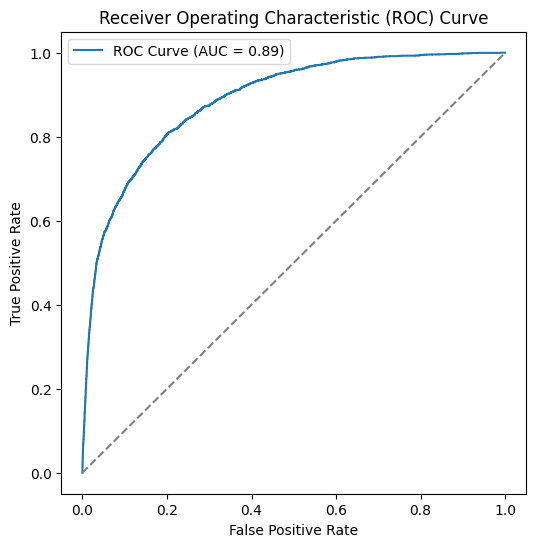

In [43]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()